In [1]:
import sys
import os

sys.path.insert(0, '/home/caron/Bureau/Model/HexagonalScale/ST-GNN-for-wildifre-prediction/Prediction')

import pandas as pd
import geopandas as gpd
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import rasterio.features
import rasterio.warp
from graph_structure import *
dir_dataset = Path('.')
from tools import quantile_prediction_error

#regions = gpd.read_file(dir_dataset / 'regions/firepoint/firemen/regions.geojson')

/home/caron/Bureau/.conda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Nom de l'hôte : caron-Precision-7780
Adresse IP locale : 127.0.1.1


/home/caron/Bureau/.conda/lib/python3.9/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [15]:
import numpy as np

def generate_weight_matrix(n_classes):
    """
    Génère une matrice de poids de taille n_classes x n_classes,
    où chaque élément représente le poids calculé entre une classe réelle
    et une classe prédite.
    
    Args:
        n_classes (int): Nombre total de classes.
    
    Returns:
        np.ndarray: Matrice de poids de taille (n_classes, n_classes).
    """
    # Initialiser la matrice de poids
    weight_matrix = np.zeros((n_classes, n_classes))
    
    # Remplir la matrice avec les poids calculés
    for true_class in range(n_classes):
        for pred_class in range(n_classes):
            weight_matrix[true_class, pred_class] = abs(true_class - pred_class) / (n_classes - 1)
    
    return weight_matrix

# Exemple avec 5 classes
n_classes = 5
weight_matrix = generate_weight_matrix(n_classes)

# Affichage de la matrice de poids
print("Matrice des poids (n x n) :\n", weight_matrix)


Matrice des poids (n x n) :
 [[0.   0.25 0.5  0.75 1.  ]
 [0.25 0.   0.25 0.5  0.75]
 [0.5  0.25 0.   0.25 0.5 ]
 [0.75 0.5  0.25 0.   0.25]
 [1.   0.75 0.5  0.25 0.  ]]


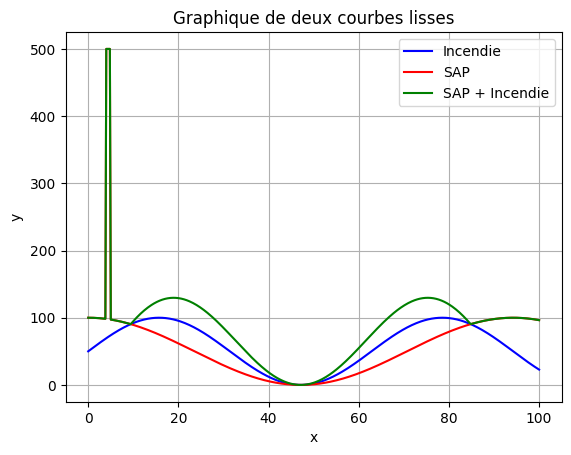

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Création de deux tableaux numpy entre 0 et 100 avec des valeurs lisses
x = np.linspace(0, 100, 500)  # 500 points pour une courbe lisse
y1 = np.sin(x / 10) * 50 + 50  # Fonction sinus pour obtenir une courbe lisse
y2 = np.cos(x / 15) * 50 + 50  # Fonction cosinus pour une autre courbe lisse

y2[20:25] 
# Tracer les deux courbes
plt.plot(x, y1, label='Incendie', color='blue')
plt.plot(x, y2, label='SAP', color='red')

th = np.maximum(y2, y1) - np.minimum(y2, y1)

plt.plot(x, y1 + th, label='SAP + Incendie', color='green')

# Ajouter un titre et des labels
plt.title('Graphique de deux courbes lisses')
plt.xlabel('x')
plt.ylabel('y')

# Ajouter une légende
plt.legend()

# Afficher le graphique
plt.grid(True)
plt.show()


In [12]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import categorical_crossentropy

# Définition de la fonction de perte personnalisée
def custom_loss(y_true, y_pred):
    weights = K.cast(K.abs(K.argmax(y_true, axis=1) - K.argmax(y_pred, axis=1)) / (K.int_shape(y_pred)[1] - 1), dtype='float32')
    print(weights)
    print(K.int_shape(y_pred)[1])
    print(K.int_shape(y_pred)[1] - 1)

    return (1.0 + weights) * categorical_crossentropy(y_true, y_pred)

# Exemple de test pour un problème multi-classes
def test_custom_loss_multiclass():
    # Cibles one-hot pour 4 classes
    y_true = tf.constant([
        [1, 0, 0, 0],  # Classe 0
        [0, 1, 0, 0],  # Classe 1
        [0, 0, 1, 0],  # Classe 2
        [0, 0, 0, 1]   # Classe 3
    ], dtype=tf.float32)
    
    # Prédictions probabilistes pour 4 classes
    y_pred = tf.constant([
        [0.8, 0.1, 0.05, 0.05],  # Classe 0 bien prédite
        [0.1, 0.7, 0.1, 0.1],    # Classe 1 bien prédite
        [0.0, 0.5, 0.2, 0.2],    # Classe 2 mal prédite avec incertitude
        [0.05, 0.05, 0.1, 0.8]   # Classe 3 bien prédite
    ], dtype=tf.float32)
    
    # Calcul de la perte
    loss_value = custom_loss(y_true, y_pred)
    
    # Affichage des résultats
    print("y_true:", y_true.numpy())
    print("y_pred:", y_pred.numpy())
    print("Perte calculée pour chaque échantillon :", loss_value.numpy())

# Lancer le test
test_custom_loss_multiclass()

tf.Tensor([0.         0.         0.33333334 0.        ], shape=(4,), dtype=float32)
4
3
y_true: [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
y_pred: [[0.8  0.1  0.05 0.05]
 [0.1  0.7  0.1  0.1 ]
 [0.   0.5  0.2  0.2 ]
 [0.05 0.05 0.1  0.8 ]]
Perte calculée pour chaque échantillon : [0.22314355 0.35667497 2.0054364  0.22314355]


0.6756756756756757 0.81

Gradient calculé numériquement : 4.99999499581349E-7
Hessienne calculée numériquement : -0.999999999999251

Gradient calculé numériquement : 4.99999499581349E-7
Hessienne calculée numériquement : -0.999999999999251

Gradient calculé numériquement : 6.24999842990803E-8
Hessienne calculée numériquement : -0.249999999999988

Gradient calculé numériquement : 6.24999842990803E-8
Hessienne calculée numériquement : -0.249999999999988

Gradient calculé numériquement : 0
Hessienne calculée numériquement : 0

Gradient calculé numériquement : -0.239999824000061
Hessienne calculée numériquement : 0.0639997696001302

Gradient calculé numériquement : 0.479999967999994
Hessienne calculée numériquement : -0.703999769600054

Gradient calculé numériquement : -0.159999948000009
Hessienne calculée numériquement : 0.0719999424000151

Gradient calculé numériquement : 7.81249950843055E-9
Hessienne calculée numériquement : -0.0624999999999998

Gradient calculé numériquement : 0.499999

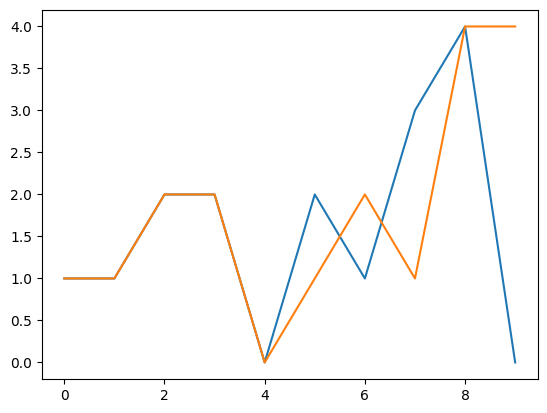

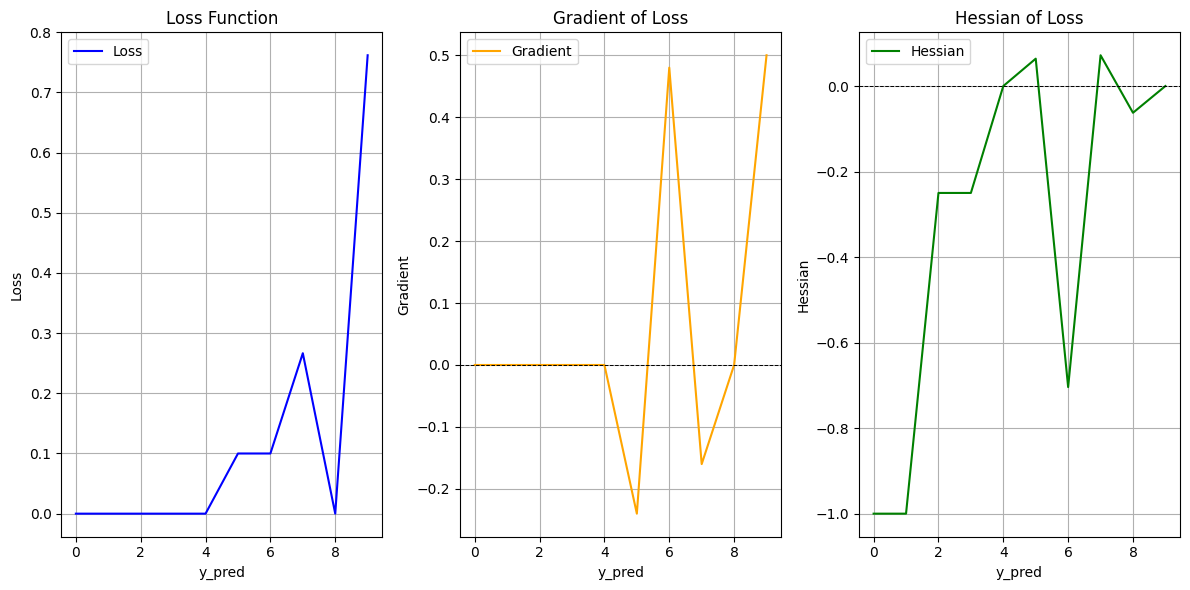

In [258]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

def visualize_loss_gradient_hessian(loss_fn, gradient_hessian_fn, y_true, y_pred_range):
    """
    Visualise la relation entre la fonction de perte, son gradient et sa hessienne.

    Parameters:
        loss_fn (callable): Fonction de perte, L(y_true, y_pred).
        gradient_fn (callable): Gradient de la perte par rapport à y_pred, ∂L/∂y_pred.
        hessian_fn (callable): Hessienne de la perte par rapport à y_pred, ∂²L/∂y_pred².
        y_true (float): La valeur réelle (vérité terrain).
        y_pred_range (np.array): Un tableau des valeurs prédites pour lesquelles calculer les métriques.

    Returns:
        None
    """
    losses = []
    gradients = []
    hessians = []

    losses = loss_fn(y_true, y_pred_range)
    gradients, hessians = gradient_hessian_fn(y_true, y_pred_range)

    # Convertir en tableaux NumPy pour faciliter les calculs et les visualisations
    losses = np.array(losses)
    gradients = np.array(gradients)
    hessians = np.array(hessians)

    # Tracé des résultats
    plt.figure(figsize=(12, 6))
    
    # Plot de la perte
    plt.subplot(1, 3, 1)
    plt.plot(losses, label="Loss", color="blue")
    plt.title("Loss Function")
    plt.xlabel("y_pred")
    plt.ylabel("Loss")
    plt.grid()
    plt.legend()

    # Plot du gradient
    plt.subplot(1, 3, 2)
    plt.plot(gradients, label="Gradient", color="orange")
    plt.title("Gradient of Loss")
    plt.xlabel("y_pred")
    plt.ylabel("Gradient")
    plt.grid()
    plt.axhline(0, color="black", linestyle="--", linewidth=0.7)
    plt.legend()

    # Plot de la hessienne
    plt.subplot(1, 3, 3)
    plt.plot(hessians, label="Hessian", color="green")
    plt.title("Hessian of Loss")
    plt.xlabel("y_pred")
    plt.ylabel("Hessian")
    plt.grid()
    plt.axhline(0, color="black", linestyle="--", linewidth=0.7)
    plt.legend()

    plt.tight_layout()
    plt.show()

def dice_coefficient(y_true, y_pred, smooth=1e-10, weight=None):
    """
    Calcul de la Dice Loss en NumPy.

    Args:
        y_pred (np.ndarray): Prédictions de forme (N, C, ...).
        y_true (np.ndarray): Cibles vraies de forme (N, ...).
        smooth (float): Paramètre pour éviter la division par zéro.
        weight (np.ndarray, optional): Poids optionnels pour chaque classe.

    Returns:
        float: La valeur de la Dice Loss.
    """
    N, C = y_pred.shape

    # Mise en forme des prédictions et des cibles
    prob = np.exp(y_pred) / np.sum(np.exp(y_pred), axis=1, keepdims=True)
    y_pred = np.argmax(prob, axis=1)

    y_pred = y_pred.reshape(N, 1)  # (N, 1, *)
    y_true = y_true.reshape(N, 1)  # (N, 1, *)
    
    # Calcul de l'intersection et de l'union
    intersection = np.sum(y_pred * y_true, axis=1)  # (N, C)
    union = np.sum(y_pred**2, axis=1) + np.sum(y_true**2, axis=1)  # (N, C)
    
    union = union.astype(np.float32)
    intersection = intersection.astype(np.float32)

    # Calcul du Dice Coefficient
    dice_coef = ((2 * intersection) + smooth) / (union + smooth) # (N, C)

    return np.array(dice_coef)

def dice_loss(y, y_pred):
    """
    Calcul de la Dice Loss pour chaque classe.
    """

    num_classes = 5
    dice = dice_coefficient(y, y_pred, num_classes)
    return 1 - dice  # La Dice Loss est 1 - Dice coefficient

def dice_loss_objective_5(y, pred):
    """
    Fonction objective pour XGBoost utilisant la Dice Loss (multi-classes).
    Retourne le gradient et le hessien pour la mise à jour des poids.
    """
    num_classes = 5  # Nombre de classes
    epsilon = 1e-10   # Pour éviter la division par zéro
    
    y_true = np.copy(y)

    # Reshape des prédictions pour obtenir (n_samples, num_classes)
    pred = pred.reshape(-1, num_classes)
    
    # Transformation softmax pour obtenir les probabilités
    prob = np.exp(pred) / np.sum(np.exp(pred), axis=1, keepdims=True)
    pred = np.argmax(prob, axis=1)

    # Initialisation des gradients et hessiens
    gradient = np.zeros_like(pred, dtype=np.float32)
    hessian = np.zeros_like(pred, dtype=np.float32)

    x = sp.Symbol('x')  # y_pred_c
    y = sp.Symbol('y', real=True)  # y_true_c est un scalaire symbolique
    epsilon = sp.Symbol('epsilon', real=True, positive=True)

    intersection = y * x
    union = y**2 + x**2
    f = (2 * intersection) / (union + epsilon)

    # Gradient (dérivée de F par rapport à x)
    grad = sp.diff(f, x)

    # Hessienne (dérivée seconde de F par rapport à x)
    hess = sp.diff(grad, x)

    # Calcul de la Dice Loss par classe
    for c in range(pred.shape[0]):
        
        y_true_c = y_true[c].astype(np.float32)
        y_pred_c = pred[c].astype(np.float32)
        
        grad_val = grad.subs({y: y_true_c, x: y_pred_c, epsilon: 1e-6}).evalf()
        hess_val = hess.subs({y: y_true_c, x: y_pred_c, epsilon: 1e-6}).evalf()

        gradient[c] = grad_val  # Stocker le gradient pour la classe c
        hessian[c] = hess_val

        #print(c, intersection, union, grad, hess)
        
    return gradient, hessian

# Exemple de valeurs pour y_true et y_pred
y_true = np.array([1, 1, 2, 2, 0, 1, 2, 1, 4, 4])  # Valeurs vraies
pred = np.array([
    [1.0, 1.5, 0.0, 0.2, 0.1],  # Probabilités prédites
    [0.1, 2.0, 0.5, 0.3, 0.1],
    [0.2, 0.3, 1.8, 0.4, 0.2],
    [0.3, 1.9, 3.0, 0.2, 0.2],
    [2.1, 0.4, 0.7, 0.2, 0.1],
    [0.2, 0.1, 2.0, 0.5, 0.1],
    [0.3, 2.1, 0.2, 0.1, 0.1],
    [0.1, 0.2, 0.1, 2.2, 0.1],
    [0.1, 0.2, 0.3, 0.2, 2.4],
    [1.9, 0.4, 0.1, 0.2, 0.2]
])  # Aplatir pour simuler l'entrée XGBoost

# Nombre de classes
num_classes = 5

prob = np.exp(pred) / np.sum(np.exp(pred), axis=1, keepdims=True)
val = np.argmax(prob, axis=1)

intersection = np.trapz(np.minimum(val, y_true))  # Aire commune
union = np.trapz(np.maximum(val, y_true))         # Aire d'union

dice_coefficient_ = round(2 * intersection / (union + intersection), 2) if union + intersection > 0 else 0

print(intersection / union, dice_coefficient_)

fig, ax = plt.subplots(1)
ax.plot(val)
ax.plot(y_true)

# Visualisation des gradients et hessiennes
visualize_loss_gradient_hessian(
    dice_loss,
    dice_loss_objective_5,
    y_true=y_true,
    y_pred_range=pred,
)

In [255]:
import sympy as sp

# Définir les variables symboliques
x = sp.Symbol('x', real=True)  # Variable pour y_pred_c
y_true_c = sp.Symbol('y_true_c', real=True)  # Variable pour y_true_c
epsilon = sp.Symbol('epsilon', real=True, positive=True)  # Petite valeur pour éviter les divisions par zéro

# Définir la fonction
intersection = y_true_c * x
union = y_true_c**2 + x**2
f = (2 * intersection) / (union + epsilon)  # Ajout de epsilon pour stabilité numérique

# Calcul symbolique
grad = sp.diff(f, x)  # Gradient (dérivée de f par rapport à x)
hess = sp.diff(grad, x)  # Hessienne (dérivée seconde de f par rapport à x)

# Afficher les expressions symboliques (facultatif)

# Exemple de valeurs pour la substitution
y_true_c_val = [0.5, 0.5]  # Exemple de valeur pour y_true_c
x_val = [0.7, 0.8]         # Exemple de valeur pour y_pred_c
epsilon_val = 1e-6  # Petite valeur pour éviter les divisions par zéro

# Substituer les valeurs et évaluer numériquement
grad_val = grad.subs({y_true_c: y_true_c_val, x: x_val, epsilon: epsilon_val}).evalf()
hess_val = hess.subs({y_true_c: y_true_c_val, x: x_val, epsilon: epsilon_val}).evalf()

# Afficher les résultats numériques
print(f"\nGradient calculé numériquement (float) : {grad_val}")
print(f"Hessienne calculée numériquement (float) : {hess_val}")


SympifyError: SympifyError: [0.5, 0.5]

In [224]:


x = sp.Symbol('x')
f = 3 * x**2 + 5 * x + 7

# Gradient (dérivée)
gradient = sp.diff(f, x)

# Hessienne (dérivée seconde)
hessian = sp.diff(gradient, x)

print(f"Dérivée (gradient) symbolique : {gradient}")
print(f"Hessienne (dérivée seconde) symbolique : {hessian}")


Dérivée (gradient) symbolique : 6*x + 5
Hessienne (dérivée seconde) symbolique : 6


In [1]:
import numpy as np
from scipy.stats import rankdata, spearmanr

data = [100, 200, 200, 300, 500, 100]
print("Average:", rankdata(data, method='average'))  # Moyenne des rangs pour les ex æquo
print("Min:", rankdata(data, method='min'))          # Rang le plus bas pour les ex æquo
print("Max:", rankdata(data, method='max'))          # Rang le plus élevé pour les ex æquo
print("Dense:", rankdata(data, method='dense'))      # Rangs consécutifs même avec ex æquo
print("Ordinal:", rankdata(data, method='ordinal'))  # Rang selon l'ordre d'apparition

Average: [1.5 3.5 3.5 5.  6.  1.5]
Min: [1 3 3 5 6 1]
Max: [2 4 4 5 6 2]
Dense: [1 2 2 3 4 1]
Ordinal: [1 3 4 5 6 2]


In [9]:
raste = read_object('departement-01-ainrasterScale3_risk-size-watershed_node_node.pkl', Path('firemen/firepoint/2x2/train/raster'))

In [15]:
min_size = 1 + 3 * 3 * 4
max_size = int(2.5 * min_size)
min_size, max_size

(37, 92)

In [12]:
for i in np.unique(raste[~np.isnan(raste)]):
    print(np.argwhere(raste == i).shape, i)

(66, 2) 0.0
(84, 2) 1.0
(41, 2) 2.0
(85, 2) 3.0
(81, 2) 4.0
(84, 2) 5.0
(61, 2) 6.0
(80, 2) 7.0
(65, 2) 8.0
(65, 2) 9.0
(83, 2) 10.0
(53, 2) 11.0
(57, 2) 12.0
(41, 2) 13.0
(39, 2) 14.0
(63, 2) 15.0
(42, 2) 16.0
(59, 2) 17.0


(<matplotlib.image.AxesImage at 0x7d09f92a8190>,
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., nan], dtype=float32))

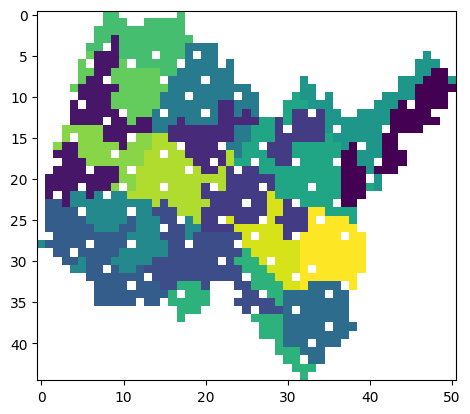

In [13]:
plt.imshow(raste), np.unique(raste)

(<matplotlib.image.AxesImage at 0x7d09f94226d0>,
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., nan], dtype=float32))

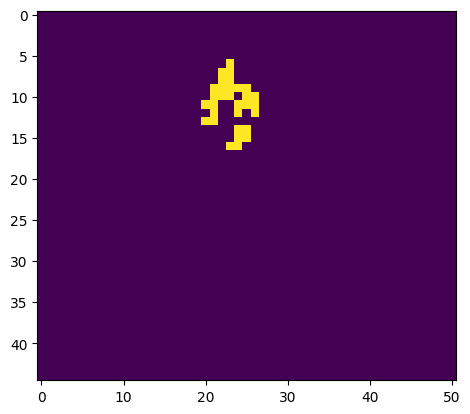

In [6]:
plt.imshow(raste == 13), np.unique(raste)

In [2]:
scale = 4 
base = 'risk-size-watershed'
graph = read_object(f'graph_{scale}_{base}_node.pkl', Path('bdiff/firepoint/2x2/train/'))

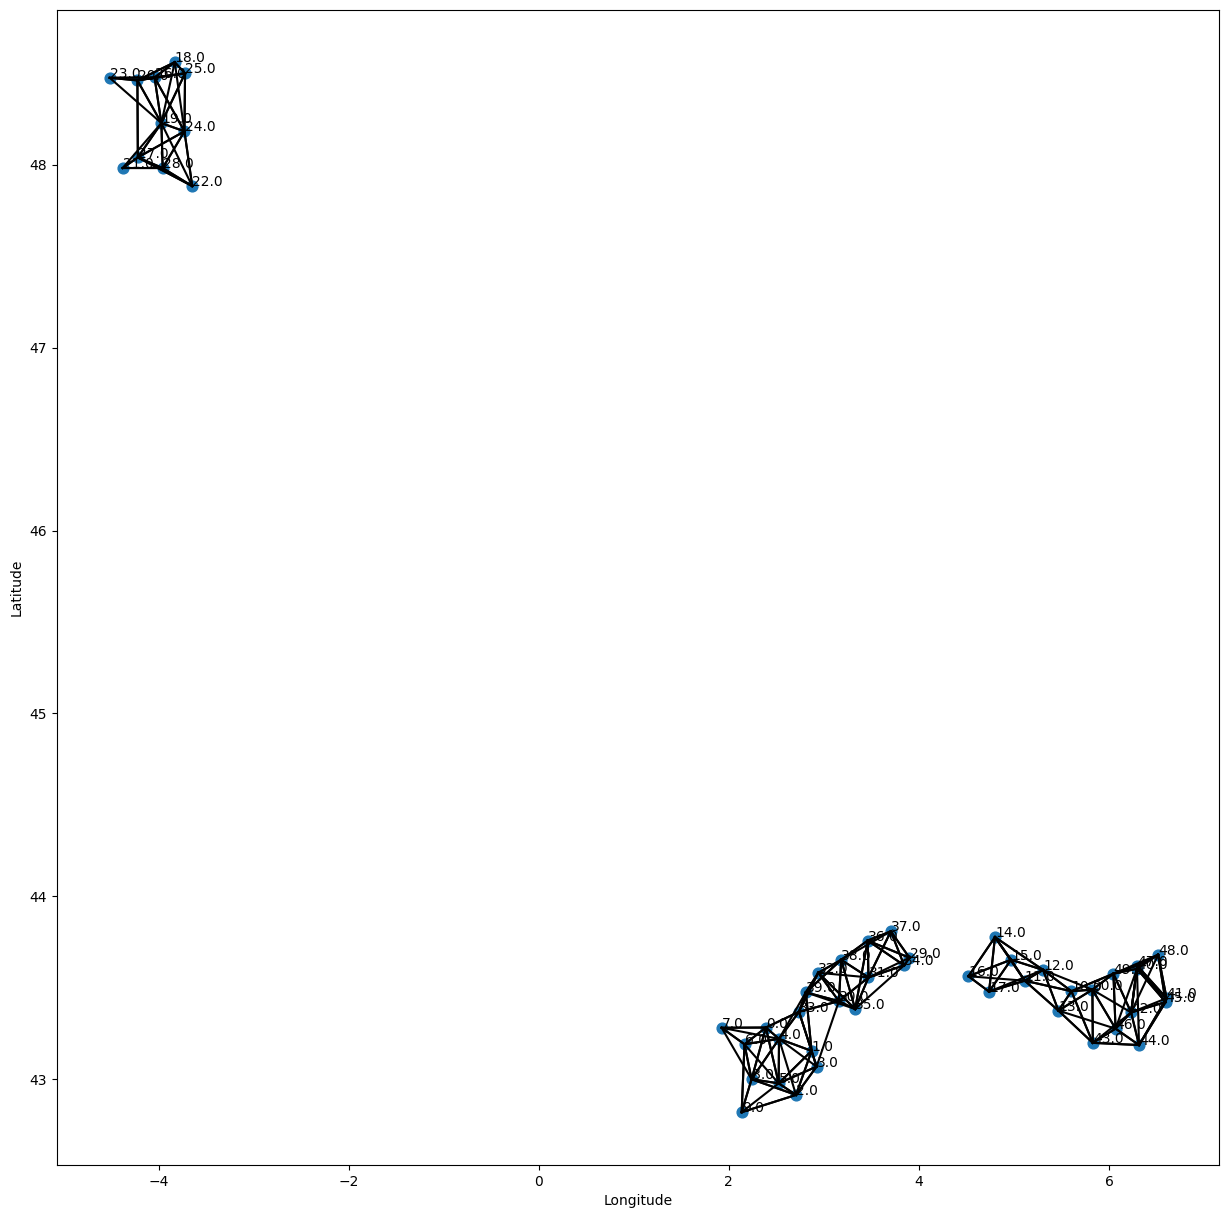

In [3]:
graph._plot(graph.nodes)

In [29]:
hexagones = graph.oriGeometry
ids = graph.ids
ids.shape, hexagones.shape

((3595,), (3595,))

In [30]:
uids = np.sort(np.unique(ids))
nbperids = []
for id in uids:
    nbperids.append(ids[ids == id].shape[0])

(8, 39)

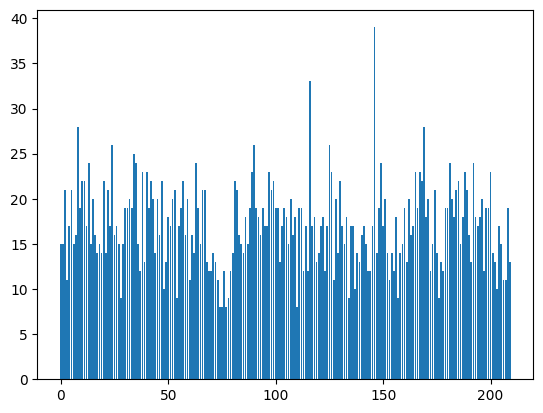

In [31]:
plt.bar(uids, nbperids)
np.min(nbperids), np.max(nbperids)

In [ ]:
plt.plot(order[:,-2])

NameError: name 'order' is not defined

In [ ]:
Y[:,-4], X[:,4]

(array([2022., 2023., 2024., ..., 2279., 2280., 2281.]),
 array([2022., 2023., 2024., ..., 2279., 2280., 2281.]))

In [ ]:
ind

array([    0,   260,   520, ..., 25999, 26259, 26519])

In [ ]:
np.argwhere

<function argwhere at 0x7f8bdc0d2370>

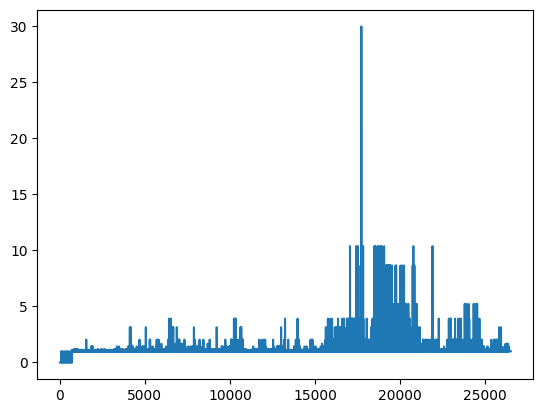

In [ ]:
plt.plot(order[:,-3])

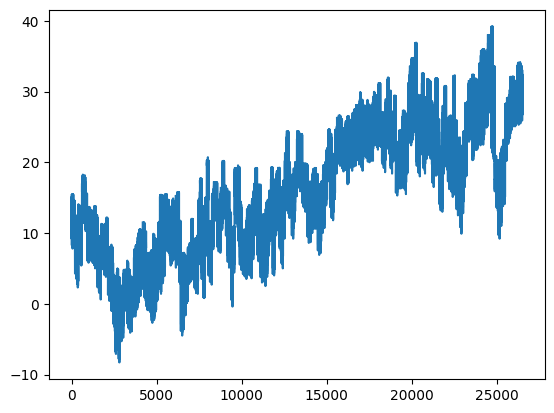

In [ ]:
plt.plot(X[ind,6])

In [ ]:
np.unique(raster)

array([  2.,   4.,   7.,   9.,  12.,  15.,  22.,  23.,  25.,  28.,  31.,
        32.,  35.,  44.,  46.,  47.,  49.,  55.,  56.,  61.,  62.,  63.,
        70.,  75.,  76.,  77.,  84.,  87.,  88.,  90.,  95.,  98.,  99.,
       101., 104., 106., 108., 111., 113.,  nan], dtype=float32)

In [ ]:
np.unique(YBin[:,-1])

array([0., 1.])

In [ ]:
np.unique(Y[:,0])

array([  0.,   1.,   2.,   3.,   4.,   5.,   7.,   8.,   9.,  10.,  12.,
        13.,  14.,  15.,  16.,  17.,  18.,  19.,  21.,  22.,  23.,  24.,
        25.,  26.,  27.,  28.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,
        39.,  40.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,
        52.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,
        64.,  65.,  67.,  70.,  71.,  72.,  73.,  75.,  76.,  77.,  79.,
        80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,
        91.,  92.,  93.,  94.,  95.,  96.,  98.,  99., 101., 103., 104.,
       105., 106., 107., 108., 109., 110., 111., 112., 113., 114., 115.,
       116., 117., 118.])

In [ ]:
YBin[YBin[:,-1] > 0][:,4], YBin[YBin[:,-1] > 0][:,0], YBin[YBin[:,-1] > 0][:,3]

(array([2072., 2092., 2137., 2217., 2218., 2219., 2221., 2223., 2236.,
        2254., 2279., 2071., 2157., 2193., 2202., 2221., 2226., 2228.,
        2229., 2233., 2257., 2074., 2177., 2206., 2247., 2258., 2084.,
        2229., 2256., 2262., 2263., 2159., 2192., 2201., 2202., 2215.,
        2256., 2047., 2219., 2244., 2253., 2263., 2267., 2192., 2063.,
        2073., 2123., 2229., 2272., 2182., 2064., 2101., 2175., 2182.,
        2195., 2201., 2204., 2216., 2203., 2186., 2236., 2262., 2040.,
        2056., 2086., 2096., 2103., 2117., 2126., 2150., 2163., 2178.,
        2184., 2186., 2193., 2194., 2207., 2209., 2218., 2223., 2226.,
        2227., 2076., 2114., 2142., 2174., 2192., 2193., 2195., 2201.,
        2219., 2226., 2242., 2249., 2263., 2264., 2084., 2102., 2175.,
        2207., 2217., 2230., 2259., 2181., 2227., 2063., 2088., 2233.,
        2254., 2262., 2222., 2265., 2037., 2127., 2192., 2228., 2073.,
        2173., 2174., 2198., 2219., 2228., 2249., 2260., 2160., 2194.,
      

<Axes: >

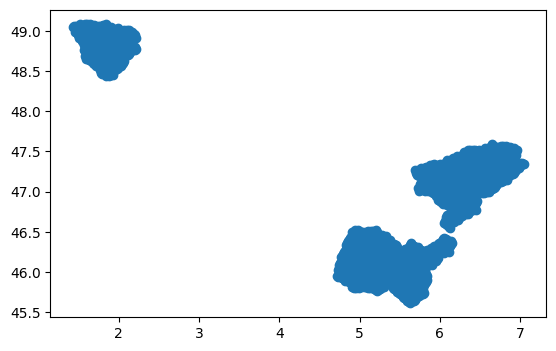

In [ ]:
test = pd.read_csv('test.csv')
testGeo = test[test['date'] == 2029]
testGeo = gpd.GeoDataFrame(testGeo, geometry=gpd.points_from_xy(testGeo.longitude, testGeo.latitude))
testGeo.plot()

In [ ]:
test

,date,latitude,longitude,scale5
0,2029,45.989310,4.850769,94
1,2029,46.055726,5.340705,57
2,2029,46.219423,4.905380,26
3,2029,45.719268,5.755522,118
4,2029,46.444826,4.929589,18
...,...,...,...,...
765573,2281,48.833885,1.752489,1
765574,2281,49.052720,1.616237,83
765575,2281,48.862643,1.976650,14
765576,2281,48.702993,1.763205,39


In [95]:
dir_dataset = Path('train')
departement = 'departement-01-ain'

name = departement+'binScale10'+'.pkl'
bin = pickle.load(open(dir_dataset / 'bin/2x2' / name, 'rb'))

name = departement+'rasterScale10'+'.pkl'
raster = pickle.load(open(dir_dataset / 'raster/2x2' / name, 'rb'))

name = departement+'influence'+'.pkl'
proba10 = pickle.load(open(dir_dataset / '../../log/' / name, 'rb'))

name = departement+'pastInfluence'+'.pkl'
proba10Past = pickle.load(open(dir_dataset / '../../log/' / name, 'rb'))

fig = plt.figure(figsize=(15,15))

temporalIndex = 1547

ax = fig.add_subplot(431)
ax.imshow(bin[:,:, temporalIndex], cmap='jet')
ax.set_title('Binary')
ax = fig.add_subplot(433)
ax.imshow(proba10[:,:,temporalIndex], cmap='jet', vmin=0, vmax=1)
ax.set_title('Proba')
ax = fig.add_subplot(434)
ax.imshow(raster == 6.0, cmap='jet')
ax = fig.add_subplot(435)
ax.imshow(proba10Past[:,:,temporalIndex], cmap='jet')
ax.set_title('Past')
plt.tight_layout()

FileNotFoundError: [Errno 2] No such file or directory: 'train/bin/2x2/departement-01-ainbinScale10.pkl'

In [ ]:
graph = read_object('graph_1.pkl', Path('train'))
graph._plot(graph.nodes)

FileNotFoundError: [Errno 2] No such file or directory: 'train/graph_1.pkl'

In [4]:
graph = read_object('graph_10.pkl', Path('exp_ks/firepoint/train'))

Y = pickle.load(open('exp_ks/firepoint/train/Y_full_10.pkl', 'rb'))
X = pickle.load(open('exp_ks/firepoint/train/X_full_10.pkl', 'rb'))

In [8]:
from config import features
features_name,_ = get_features_name_list(graph, 6, features)
features_name

{'temp': 6,
 'dwpt': 10,
 'rhum': 14,
 'prcp': 18,
 'wdir': 22,
 'wspd': 26,
 'prec24h': 30,
 'dc': 34,
 'ffmc': 38,
 'dmc': 42,
 'nesterov': 46,
 'munger': 50,
 'kbdi': 54,
 'isi': 58,
 'angstroem': 62,
 'bui': 66,
 'fwi': 70,
 'dailySeverityRating': 74,
 'temp16': 78,
 'dwpt16': 82,
 'rhum16': 86,
 'prcp16': 90,
 'wdir16': 94,
 'wspd16': 98,
 'prec24h16': 102,
 'elevation': 106,
 'highway': 110,
 'population': 114,
 'sentinel': 118,
 'landcover': 138,
 'foret': 142,
 'Calendar': 146,
 'Historical': 157,
 'Geo': 161,
 'air': 162}

In [15]:
np.unique(X[:, features_name.index('landcover') + 2])

array([0.009, 0.012, 0.017, 0.019, 0.036, 0.044])

In [ ]:
np.unique(X[:,features_name.index('foret') + 2])

array([0.097, 0.099, 0.114, 0.157, 0.185])

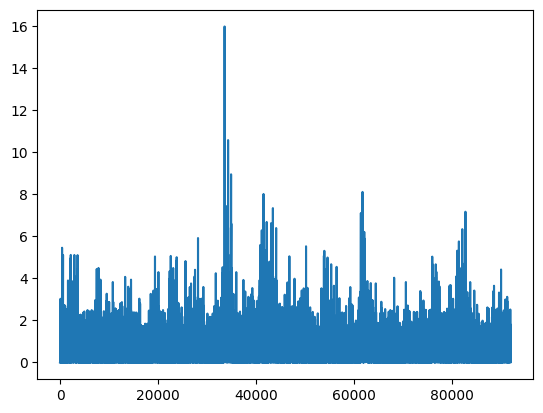

In [ ]:
plt.plot(Y[:,-1])

In [ ]:
from tools import *

features_name,_ = get_features_name_list(read_object('graph_5.pkl', Path('train/')), 6, features)

6 temp
10 dwpt
14 rhum
18 prcp
22 wdir
26 wspd
30 prec24h
34 dc
38 ffmc
42 dmc
46 nesterov
50 munger
54 kbdi
58 isi
62 angstroem
66 bui
70 fwi
74 daily_severity_rating
78 temp16
82 dwpt16
86 rhum16
90 prcp16
94 wdir16
98 wspd16
102 prec24h16
106 elevation
110 highway
114 population
118 sentinel
138 landcover
142 foret
146 Calendar
157 Historical
161 Geo
162 air


In [ ]:
np.unique(X[:,features_name.index('foret')])

array([0.072, 0.074, 0.077, 0.078, 0.079, 0.08 , 0.082, 0.084, 0.086,
       0.088, 0.089, 0.091, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098,
       0.099, 0.1  ])

In [ ]:
np.unique(X[:,features_name.index('landcover')])

array([0.015, 0.024, 0.028, 0.03 , 0.033, 0.036, 0.038, 0.039, 0.04 ,
       0.041, 0.042, 0.043, 0.045, 0.046, 0.047, 0.048, 0.049, 0.05 ,
       0.051, 0.052, 0.053, 0.054, 0.055, 0.056, 0.057, 0.058, 0.059,
       0.06 , 0.061, 0.062, 0.063, 0.064, 0.065, 0.066, 0.067, 0.068,
       0.069, 0.07 , 0.071, 0.072, 0.073, 0.074, 0.075, 0.076, 0.077,
       0.078, 0.079, 0.08 , 0.081, 0.082, 0.083, 0.084, 0.085, 0.086,
       0.087, 0.088, 0.089, 0.09 , 0.091, 0.092, 0.093, 0.094, 0.095,
       0.096, 0.097, 0.098, 0.099, 0.1  , 0.101, 0.102, 0.103, 0.104,
       0.105, 0.106, 0.107, 0.108, 0.109, 0.11 , 0.111, 0.112, 0.113,
       0.114, 0.115, 0.116, 0.117, 0.118, 0.119, 0.12 , 0.121, 0.122,
       0.123, 0.124, 0.125, 0.126, 0.127, 0.128, 0.129, 0.13 , 0.131,
       0.132, 0.133, 0.134, 0.135, 0.136, 0.137, 0.138, 0.139, 0.14 ,
       0.141, 0.142, 0.143, 0.144, 0.145, 0.146, 0.147, 0.148, 0.149,
       0.15 , 0.151, 0.152, 0.153, 0.154, 0.155, 0.156, 0.157, 0.158,
       0.159, 0.16 ,

In [ ]:
X[:,108].min(), X[:,108].max()

(46.29600143432617, 1353.8330078125)

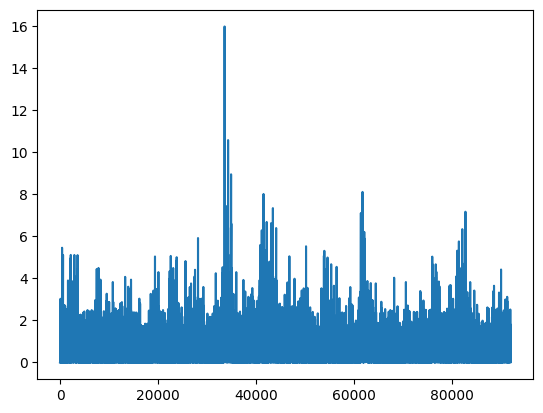

In [ ]:
plt.plot(Y[:,-1])

In [ ]:
np.mean(Y[:,-2])

0.07159385965865264

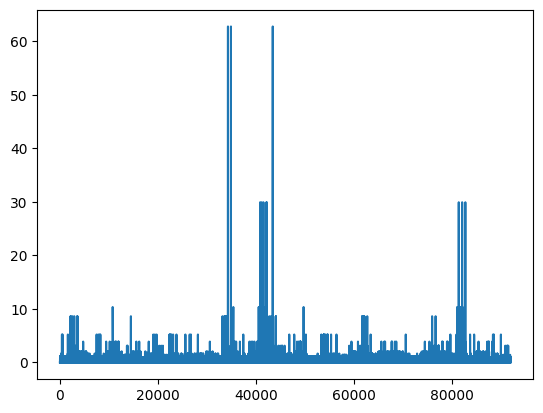

In [ ]:
plt.plot(Y[:,-3])

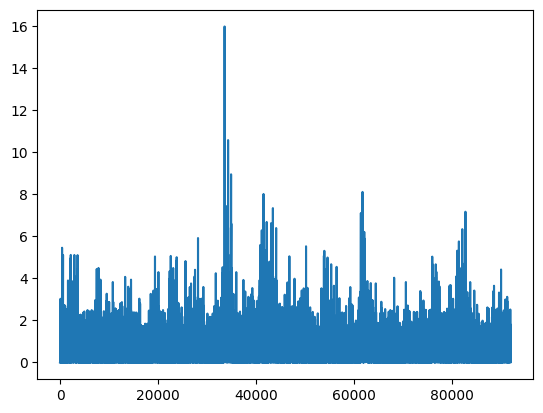

In [ ]:
plt.plot(Y[:,-1])


In [34]:
Y = pickle.load(open('final/firepoint/1x1/train/Y_full_10.pkl', 'rb'))
X = pickle.load(open('train/X_100_7_10.pkl', 'rb'))
np.unique(np.argwhere(np.isnan(X[:,6:]))).shape

FileNotFoundError: [Errno 2] No such file or directory: 'train/X_100_7_10.pkl'

In [ ]:
get_features_name_list(graph, 6, features)

6 temp
10 dwpt
14 rhum
18 prcp
22 wdir
26 wspd
30 prec24h
34 dc
38 ffmc
42 dmc
46 nesterov
50 munger
54 kbdi
58 isi
62 angstroem
66 bui
70 fwi
74 daily_severity_rating
78 temp16
82 dwpt16
86 rhum16
90 prcp16
94 wdir16
98 wspd16
102 prec24h16
106 elevation
110 highway
114 population
118 sentinel
138 landcover
142 foret
146 Calendar
157 Historical
161 Geo
162 air


({'temp': 6,
  'dwpt': 10,
  'rhum': 14,
  'prcp': 18,
  'wdir': 22,
  'wspd': 26,
  'prec24h': 30,
  'dc': 34,
  'ffmc': 38,
  'dmc': 42,
  'nesterov': 46,
  'munger': 50,
  'kbdi': 54,
  'isi': 58,
  'angstroem': 62,
  'bui': 66,
  'fwi': 70,
  'daily_severity_rating': 74,
  'temp16': 78,
  'dwpt16': 82,
  'rhum16': 86,
  'prcp16': 90,
  'wdir16': 94,
  'wspd16': 98,
  'prec24h16': 102,
  'elevation': 106,
  'highway': 110,
  'population': 114,
  'sentinel': 118,
  'landcover': 138,
  'foret': 142,
  'Calendar': 146,
  'Historical': 157,
  'Geo': 161,
  'air': 162},
 166)

In [ ]:
X, Y = remove_nan_nodes(X, Y)
X.shape

(84085, 166)

In [ ]:
Y.shape, X.shape

((157409, 8), (157409, 162))

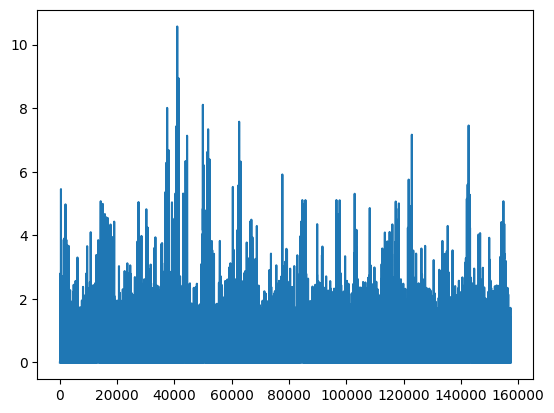

In [ ]:
plt.plot(Y[:,-1])

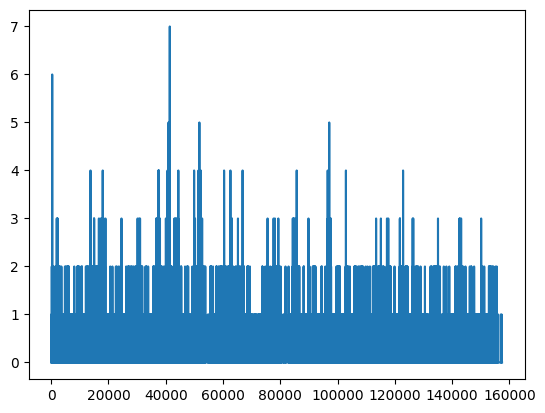

In [ ]:
plt.plot(Y[:,-2])

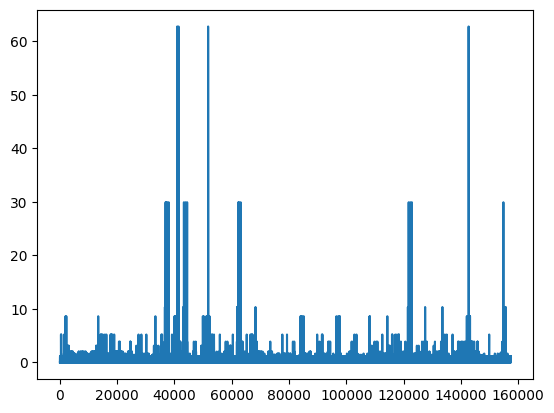

In [ ]:
plt.plot(Y[:,-3])

In [ ]:
ind = np.lexsort([Y[:,4]])
order = Y[ind]
X = X[ind]

In [ ]:
order.shape

(157409, 8)

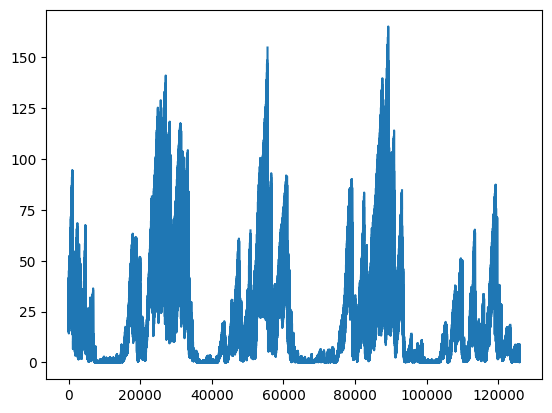

In [ ]:
plt.plot(X[:int(X.shape[0] * 0.8),42])

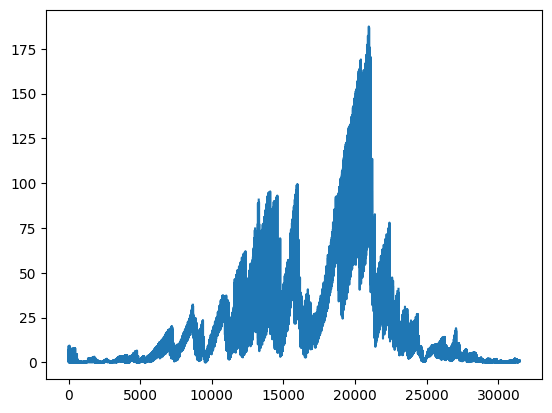

In [ ]:
plt.plot(X[int(X.shape[0] * 0.8):,42])

(array([1.56567249e+00, 1.92491749e-01, 4.91568051e-02, 4.88923273e-02,
        1.95112484e-02, 7.66985611e-03, 4.07536242e-03, 2.04369207e-03,
        1.10599806e-03, 7.69389955e-04, 3.00542951e-04, 2.04369207e-04,
        1.32238898e-04, 1.08195462e-04, 6.01085902e-05, 3.60651541e-05,
        1.20217180e-05, 1.20217180e-05, 3.60651541e-05, 3.60651541e-05]),
 array([ 0.     ,  0.52845,  1.0569 ,  1.58535,  2.1138 ,  2.64225,
         3.1707 ,  3.69915,  4.2276 ,  4.75605,  5.2845 ,  5.81295,
         6.3414 ,  6.86985,  7.3983 ,  7.92675,  8.4552 ,  8.98365,
         9.5121 , 10.04055, 10.569  ]),
 <BarContainer object of 20 artists>)

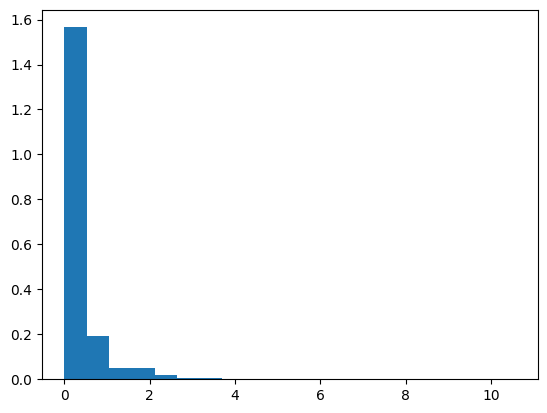

In [ ]:
plt.hist(Y[:,-1], density=True, bins=20)

(array([1.46249e+05, 8.15600e+03, 2.26100e+03, 5.09000e+02, 1.56000e+02,
        4.20000e+01, 2.00000e+01, 8.00000e+00, 2.00000e+00, 6.00000e+00]),
 array([ 0.    ,  1.0569,  2.1138,  3.1707,  4.2276,  5.2845,  6.3414,
         7.3983,  8.4552,  9.5121, 10.569 ]),
 <BarContainer object of 10 artists>)

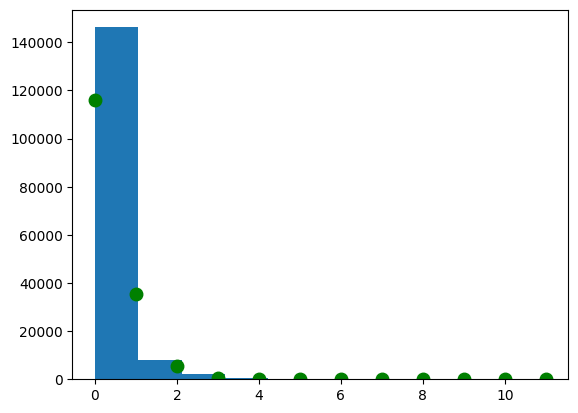

In [ ]:
import scipy

k = np.arange(np.max(Y[:,-1])+1)
plt.plot(k, scipy.stats.poisson.pmf(k, np.mean(Y[:,-1]))*len(Y[:,-1]), 'go', markersize=9)
plt.hist(Y[:,-1], bins=np.max(np.unique(Y[:,-1].astype(int))))

In [84]:
firepoint = pd.read_csv('/home/caron/Bureau/csv/departement-78-yvelines/firepoint/NATURELSfire.csv')
X = list(zip(firepoint.longitude, firepoint.latitude))
firepoint['scale'] = graph._predict_node_with_position(X)
firepoint['label'] = 1
len(firepoint)
firepoint = firepoint.groupby(by=['date', 'scale'])['label'].sum().reset_index()
len(firepoint)
firepoint = firepoint[firepoint['date'].isin(allDates)]
firepoint['date'] = [allDates.index(date) for date in firepoint.date if date in allDates]
y = firepoint.label
x = firepoint.date

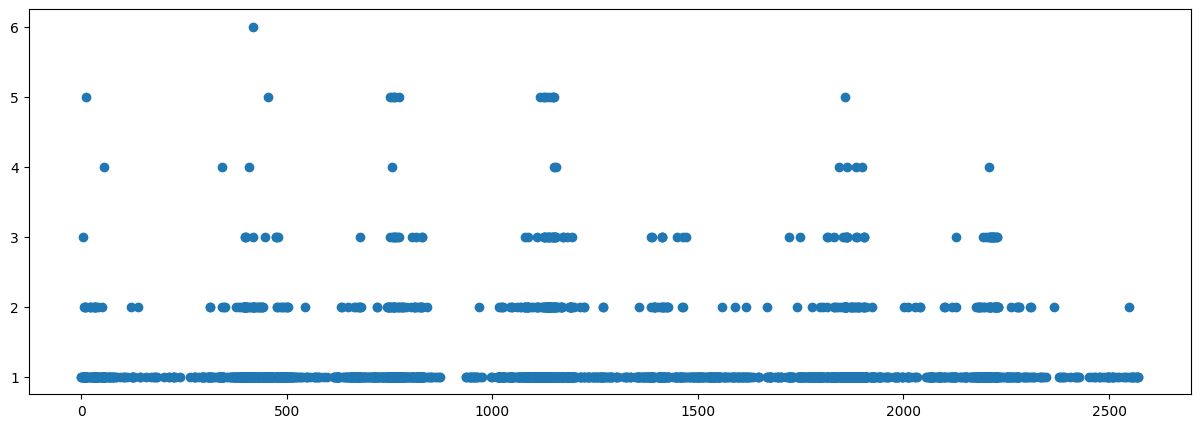

In [91]:
plt.figure(figsize=(15,5))
#plt.scatter(orderBin[Y[:,3] == 25][:,4], order[order[:,3] == 25][:,-2])
#plt.scatter(orderBin[order[:,3] == 25][:,4], order[order[:,3] == 25][:,-1])
plt.scatter(order[(order[:,3] == 78) & (order[:, -2] > 0)][:,4], order[(order[:,3] == 78) & (order[:, -2] > 0)][:,-2])
#plt.scatter(x, y, c='red')

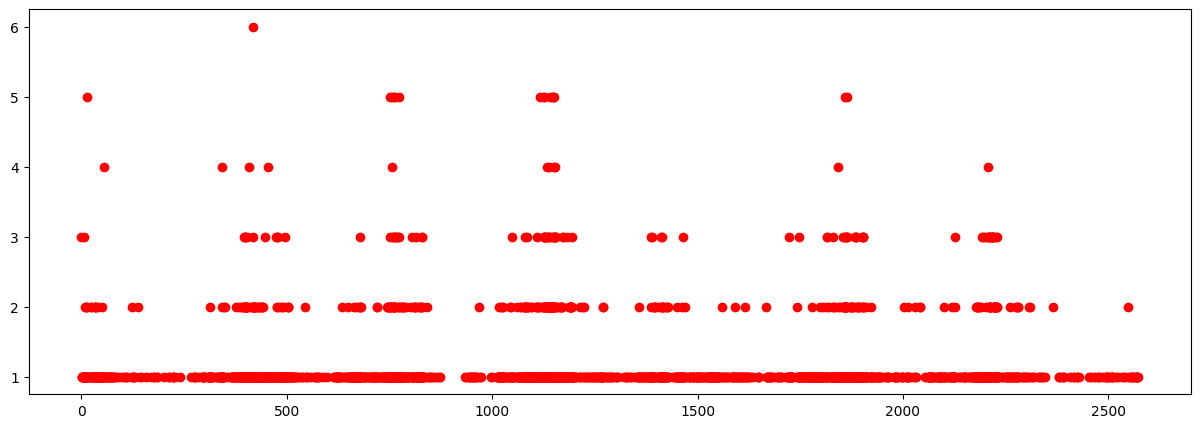

In [93]:
plt.figure(figsize=(15,5))
plt.scatter(x, y, c='red')

In [90]:
nomatch = np.argwhere(y != order[(order[:,3] == 78) & (order[:, -2] > 0)][:, -2])[:, 0]
plt.scatter(x[nomatch], y[nomatch])

ValueError: ('Lengths must match to compare', (2255,), (2240,))

In [94]:
forder = order[(order[:,3] == 78) & (order[:, -2] > 0)]
forder.shape

(2240, 8)

In [77]:
np.sum(y), order[order[:,3] == 78][:,-2].sum()

(2761.0, 2823.0)

In [ ]:
reg = gpd.read_file('regions.geojson')
reg

,geometry


In [ ]:
strange = fdate[~np.isin(fdate, x.values)]
strange

array([], dtype=float64)

In [6]:
features_name, _ = get_features_name_list(graph, 6, features)

6 temp
10 dwpt
14 rhum
18 prcp
22 wdir
26 wspd
30 prec24h
34 dc
38 ffmc
42 dmc
46 nesterov
50 munger
54 kbdi
58 isi
62 angstroem
66 bui
70 fwi
74 daily_severity_rating
78 temp16
82 dwpt16
86 rhum16
90 prcp16
94 wdir16
98 wspd16
102 prec24h16
106 elevation
110 highway
114 population
118 sentinel
138 landcover
142 foret
146 Calendar
157 Historical
161 Geo
162 air


In [7]:
features_name

{'temp': 6,
 'dwpt': 10,
 'rhum': 14,
 'prcp': 18,
 'wdir': 22,
 'wspd': 26,
 'prec24h': 30,
 'dc': 34,
 'ffmc': 38,
 'dmc': 42,
 'nesterov': 46,
 'munger': 50,
 'kbdi': 54,
 'isi': 58,
 'angstroem': 62,
 'bui': 66,
 'fwi': 70,
 'daily_severity_rating': 74,
 'temp16': 78,
 'dwpt16': 82,
 'rhum16': 86,
 'prcp16': 90,
 'wdir16': 94,
 'wspd16': 98,
 'prec24h16': 102,
 'elevation': 106,
 'highway': 110,
 'population': 114,
 'sentinel': 118,
 'landcover': 138,
 'foret': 142,
 'Calendar': 146,
 'Historical': 157,
 'Geo': 161,
 'air': 162}

In [8]:
keys = list(features_name.keys())

In [10]:
methods = ['min', 'mean', 'max', 'std']

In [26]:
cems_variables = ['temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'prec24h',
                'dc', 'ffmc', 'dmc', 'nesterov', 'munger', 'kbdi',
                'isi', 'angstroem', 'bui', 'fwi', 'daily_severity_rating',
                'temp16', 'dwpt16', 'rhum16', 'prcp16', 'wdir16', 'wspd16', 'prec24h16']

sentinel_variables = ['NDVI', 'NDMI', 'NDBI', 'NDSI', 'NDWI']
landcover_variables = ['landcover']
foret_variables = ['foret']
osmnx_variables = ['highway']
elevation_variables = ['elevation']
population_variabes = ['population']
calendar_variables = ['month', 'dayofweek', 'dayofyear', 'isweekend', 'couvrefeux', 'confinemenent',
                    'ramadan', 'bankHolidays', 'bankHolidaysEve', 'holidays', 'holidaysBorder']
geo_variables = ['departement']
historical_variables = ['influence']
air_variables = ['O3', 'NO2', 'PM10', 'PM25']

In [44]:
fet = [[157,   9],
       [159,   9],
       [ 43,   7],
       [158,   7],
       [ 44,   7],
       [ 42,   7],
       [ 67,   6],
       [ 54,   6],
       [ 55,   6],
       [ 46,   6],
       [ 68,   6],
       [ 47,   6],
       [ 66,   6],
       [160,   6],
       [ 56,   6],
       [ 48,   6],
       [ 94,   5],
       [138,   5],
       [ 34,   5],
       [ 45,   5],
       [135,   5],
       [ 60,   5],
       [ 62,   5],
       [141,   5],
       [165,   5],
       [ 35,   5],
       [114,   5],
       [ 39,   5],
       [ 37,   5],
       [ 52,   5],
       [ 96,   5],
       [ 69,   5],
       [115,   5],
       [ 71,   5],
       [ 88,   5],
       [ 50,   5],
       [133,   5],
       [ 40,   5],
       [163,   5],
       [ 57,   5],
       [ 72,   5],
       [ 59,   5],
       [ 36,   5],
       [ 38,   5],
       [ 49,   5],
       [146,   4],
       [ 95,   4],
       [106,   4],
       [108,   4],
       [ 85,   4],
       [140,   4],
       [ 87,   4],
       [ 51,   4],
       [ 53,   4],
       [ 64,   4],
       [147,   4],
       [136,   4],
       [134,   4],
       [  7,   4],
       [117,   4],
       [139,   4],
       [ 22,   4],
       [130,   4],
       [ 24,   4],
       [ 41,   4],
       [107,   4],
       [162,   4],
       [122,   4],
       [109,   4],
       [120,   4],
       [ 14,   4],
       [ 58,   4],
       [ 16,   4],
       [137,   4],
       [ 86,   4],
       [116,   4],
       [ 76,   4],
       [118,   3],
       [ 32,   3],
       [124,   3],
       [ 97,   3],
       [ 75,   3],
       [103,   3],
       [ 79,   3],
       [ 65,   3],
       [144,   3],
       [161,   3],
       [110,   3],
       [112,   3],
       [123,   3],
       [ 10,   3],
       [ 63,   3],
       [ 12,   3],
       [102,   3],
       [ 23,   3],
       [ 78,   3],
       [119,   3],
       [ 84,   3],
       [121,   3],
       [132,   3]]


for fe in fet:
    f = fe[0]
    for i, key in enumerate(keys):
        res = features_name.index(keys[i)]
        try:
            next = features_name.index(keys[i + 1)]
        except Exception as e:
                next =  None
        if next != None:
            if f >= res and f < next:
                if keys[i] in cems_variables or keys[i] == 'elevation' or \
                keys[i] == 'population' or keys[i] == 'highway' or keys[i] == 'foret' or keys[i] == 'Historical':
                    print(keys[i], fe[1], methods[f-res])
                if keys[i] == 'sentinel':
                    for i, v in enumerate(sentinel_variables):
                        if f >= (i * 4) + res and (i + 1) * 4 + res > f:
                            meth_index = f - ((i * 4) + res)
                            print(v, fe[1], methods[meth_index])

                elif keys[i] == 'Calendar':
                    print(keys[i], fe[1], calendar_variables[f-res])
        else:
            if f >= res:
                print(keys[i], fe[1], air_variables[f-res])

Historical 9 min
Historical 9 max
dmc 7 mean
Historical 7 mean
dmc 7 max
dmc 7 min
bui 6 mean
kbdi 6 min
kbdi 6 mean
nesterov 6 min
bui 6 max
nesterov 6 mean
bui 6 min
Historical 6 std
kbdi 6 max
nesterov 6 max
wdir16 5 min
dc 5 min
dmc 5 std
NDWI 5 mean
isi 5 max
angstroem 5 min
air 5 PM25
dc 5 mean
population 5 min
ffmc 5 mean
dc 5 std
munger 5 max
wdir16 5 max
bui 5 std
population 5 mean
fwi 5 mean
rhum16 5 max
munger 5 min
NDSI 5 std
ffmc 5 max
air 5 NO2
kbdi 5 std
fwi 5 max
isi 5 mean
dc 5 max
ffmc 5 min
nesterov 5 std
Calendar 4 month
wdir16 4 mean
elevation 4 min
elevation 4 max
dwpt16 4 std
rhum16 4 mean
munger 4 mean
munger 4 std
angstroem 4 max
Calendar 4 dayofweek
NDWI 4 max
NDWI 4 min
temp 4 mean
population 4 std
wdir 4 min
NDSI 4 min
wdir 4 max
ffmc 4 std
elevation 4 mean
air 4 O3
NDMI 4 min
elevation 4 std
NDVI 4 max
rhum 4 min
isi 4 min
rhum 4 max
NDWI 4 std
rhum16 4 min
population 4 max
daily_severity_rating 4 max
NDVI 3 min
prec24h 3 max
NDMI 3 max
wdir16 3 std
daily_s

In [37]:
graph = pickle.load(open('train/graph_10.pkl', 'rb'))

Y = pickle.load(open('train/Y_100_7_10.pkl', 'rb'))
X = pickle.load(open('train/X_100_7_10.pkl', 'rb'))
np.unique(np.argwhere(np.isnan(X[:,6:]))).shape

(7082,)

In [ ]:
for var in features:
    print(var)
    plt.scatter(X[:,features_name.index(var)], Y[:,-1])
    plt.ylabel('label')
    plt.xlabel(var)
    plt.title(var)
    plt.savefig('varOnValue/'+var+'.png')
    plt.close('all')

temp
dwpt
rhum
prcp
wdir
wspd
prec24h
dc
ffmc
dmc
nesterov
munger
kbdi
isi
angstroem
bui
fwi
daily_severity_rating
temp16
dwpt16
rhum16
prcp16
wdir16
wspd16
prec24h16
elevation
highway
population
sentinel
landcover
foret
Calendar
Historical
Geo
air


In [ ]:
allDates.index('2023-01-01') / 5

405.8

In [38]:
from features_selection import *

X, Y = remove_nan_nodes(X, Y)

variables = []
df = pd.DataFrame(index=np.arange(X.shape[0]))
for i in range(X.shape[1]):
    if i >= 6:
        variables.append(i)
        df[i] = X[:,i]

df['target'] = Y[:,-1]

features_importance = get_features(df, variables, target='target', num_feats=100)

In [39]:
features_importance = get_features(df, variables, target='target', num_feats=100)

=> Recherche des features pertinentes
   - Grande variance
   - Coefficient de corrélation de Pearson
   - Coefficient de corrélation de Kendall
   - Coefficient de corrélation de Spearman
   - Random forests
   - Régression linéaire
[  0  15  56  59 105 107 112 114 115 116 120 124 127 128 129 131 132 133
 134 135 138 139 140 143 144 146 149 151 152 153 154 155]
   - Extra trees
   - XGBoost
   - LightGBM
   - Lasso
Fitting estimator with 160 features.


In [40]:
features_importance = np.asarray(features_importance)
features_importance

array([[157,   9],
       [159,   9],
       [ 43,   7],
       [158,   7],
       [ 44,   7],
       [ 42,   7],
       [ 67,   6],
       [ 54,   6],
       [ 55,   6],
       [ 46,   6],
       [ 68,   6],
       [ 47,   6],
       [ 66,   6],
       [160,   6],
       [ 56,   6],
       [ 48,   6],
       [ 94,   5],
       [138,   5],
       [ 34,   5],
       [ 45,   5],
       [135,   5],
       [ 60,   5],
       [ 62,   5],
       [141,   5],
       [165,   5],
       [ 35,   5],
       [114,   5],
       [ 39,   5],
       [ 37,   5],
       [ 52,   5],
       [ 96,   5],
       [ 69,   5],
       [115,   5],
       [ 71,   5],
       [ 88,   5],
       [ 50,   5],
       [133,   5],
       [ 40,   5],
       [163,   5],
       [ 57,   5],
       [ 72,   5],
       [ 59,   5],
       [ 36,   5],
       [ 38,   5],
       [ 49,   5],
       [146,   4],
       [ 95,   4],
       [106,   4],
       [108,   4],
       [ 85,   4],
       [140,   4],
       [ 87,   4],
       [ 51,

In [42]:
np.unique(features_importance[:,0])

array([  7,  10,  12,  14,  16,  22,  23,  24,  32,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  62,  63,  64,
        65,  66,  67,  68,  69,  71,  72,  75,  76,  78,  79,  84,  85,
        86,  87,  88,  94,  95,  96,  97, 102, 103, 106, 107, 108, 109,
       110, 112, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       130, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 144, 146,
       147, 157, 158, 159, 160, 161, 162, 163, 165])

In [ ]:
np.unique(features_importance[:,0])

array([  7,  10,  13,  14,  16,  22,  23,  24,  25,  28,  32,  34,  35,
        36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
        49,  50,  52,  53,  54,  55,  56,  57,  58,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  74,  75,  76,  77,  78,  79,
        80,  82,  86,  87,  88,  94,  96,  97,  99, 106, 107, 108, 109,
       110, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 124, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 140, 141, 142, 145, 146,
       147, 148, 157, 158, 159, 160, 162, 163, 165])

In [ ]:
features_name

{'temp': 6,
 'dwpt': 10,
 'rhum': 14,
 'prcp': 18,
 'wdir': 22,
 'wspd': 26,
 'prec24h': 30,
 'dc': 34,
 'ffmc': 38,
 'dmc': 42,
 'nesterov': 46,
 'munger': 50,
 'kbdi': 54,
 'isi': 58,
 'angstroem': 62,
 'bui': 66,
 'fwi': 70,
 'daily_severity_rating': 74,
 'temp16': 78,
 'dwpt16': 82,
 'rhum16': 86,
 'prcp16': 90,
 'wdir16': 94,
 'wspd16': 98,
 'prec24h16': 102,
 'elevation': 106,
 'highway': 110,
 'population': 114,
 'sentinel': 118,
 'landcover': 138,
 'Calendar': 147,
 'Historical': 158}

In [ ]:
np.sum(YBin[:,-1])

1970.0

In [ ]:
YBin[YBin[:,-1] > 0][:,4], YBin[YBin[:,-1] > 0][:,0], YBin[YBin[:,-1] > 0][:,3]

(array([1564., 1564., 1546., ...,  307.,  736., 1867.]),
 array([78., 65.,  6., ..., 65.,  9.,  9.]),
 array([1., 1., 1., ..., 1., 1., 1.]))

In [ ]:
firepoint[firepoint['date'] == 2074]

,date_debut,date_fin,1er engin SLL,raison_sortie,date,geometry,latitude,longitude,IN,type,coef,label,altitude,h3,scale
2768,2023-02-15 17:06:24,2023-02-15 17:38:51,2023-02-15 17:16:21,NATURELS,2074,POINT (6.052971523002236 47.24917343655492),47.249173,6.052972,True,NATURELS,1,1,0.0,871f828aaffffff,23


In [ ]:
allDates[temporalIndex]

'2023-03-13'

In [ ]:
allDates.index('2023-01-01')

2029

In [ ]:
np.nansum(bin[:,:, 1010] >  0), np.nanmax(bin[:,:, 2029:]), np.nanmin(bin[:,:, 2029:]), np.nanstd(bin[:,:, 2029:])

(4, 2.0, 0.0, 0.028554290758831088)

In [ ]:
proba10Past[raster == 0, 856]

array([ 2.04796964e-17,  2.45788944e-17,  3.22548681e-17,  4.16948884e-17,
        6.05749707e-18,  3.86229960e-17,  3.43771194e-17,  2.27812935e-17,
        1.37965494e-02, -5.67756210e-18,  2.10801786e-17,  6.74128280e-17,
        5.66986264e-17,  5.50982229e-17,  1.43123083e-02,  3.97416285e-17,
        8.02034874e-17,  6.32799493e-17,  7.14692910e-17,  1.50138920e-02,
        7.68593678e-17,  6.87979485e-17,  7.12450784e-17,  6.13157433e-17,
        4.50265909e-17,  1.74024658e-02,  6.37854715e-17,  5.45776444e-17,
        5.34601168e-17])

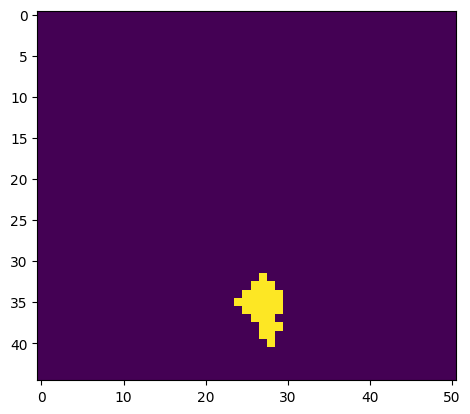

In [ ]:
plt.imshow(raster == 0)

In [ ]:
np.unique(bin)

array([ 30.,  47.,  60.,  67.,  86.,  87.,  89.,  90., 105., 115., 119.,
       134., 150., 152., 156., 161., 165., 181., 201., 214., 240., 244.,
        nan])

In [ ]:
geo = gpd.read_file(dir_dataset / '../scales' / 'regions.geojson')
graphScale = GraphStructure(1, geo, 500.0, 6, True)
graphScale._train_kmeans()

TypeError: __init__() takes 5 positional arguments but 6 were given

In [ ]:
graph = pickle.load(open('test/2023/graph_5.pkl', 'rb'))
graph._plot(graph.nodes)

In [ ]:
firepoint = pd.read_csv('/home/caron/Bureau/csv/departement-25-doubs/firepoint/NATURELSfire.csv')
X = list(zip(firepoint.longitude, firepoint.latitude))
firepoint['scale'] = graph._predict_node_with_position(X)
len(firepoint)
firepoint = firepoint.drop_duplicates(subset=('scale', 'date'))
len(firepoint)

2743

2746

In [ ]:
firepoint[firepoint['date'] >= '2023-01-01']

,date_debut,date_fin,1er engin SLL,raison_sortie,date,geometry,latitude,longitude,IN,type,coef,label,altitude,h3,scale
2764,2023-01-01 18:22:27,2023-01-01 19:15:29,2023-01-01 18:36:28,NATURELS,2023-01-01,POINT (6.379721630606588 47.04856308248432),47.048563,6.379722,True,NATURELS,1,1,0.0,871f82076ffffff,113
2765,2023-01-10 18:09:48,2023-01-10 19:51:29,-,NATURELS,2023-01-10,POINT (6.252583644154578 47.30947220067402),47.309472,6.252584,True,NATURELS,1,1,260.0,871f828e1ffffff,90
2766,2023-02-09 18:13:13,2023-02-09 19:34:54,2023-02-09 18:26:13,NATURELS,2023-02-09,POINT (6.882795615283376 47.42495144013152),47.424951,6.882796,True,NATURELS,1,1,0.0,871f82b4bffffff,111
2767,2023-02-13 17:38:28,2023-02-13 19:30:55,2023-02-13 17:59:03,NATURELS,2023-02-13,POINT (6.80571257239119 47.34940666527785),47.349407,6.805713,True,NATURELS,1,1,0.0,871f82a70ffffff,63
2768,2023-02-15 17:06:24,2023-02-15 17:38:51,2023-02-15 17:16:21,NATURELS,2023-02-15,POINT (6.052971523002236 47.24917343655492),47.249173,6.052972,True,NATURELS,1,1,0.0,871f828aaffffff,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2975,2023-09-02 15:19:34,2023-09-02 17:29:32,2023-09-02 15:35:53,NATURELS,2023-09-02,POINT (6.088833947084734 47.341352484097094),47.341352,6.088834,True,NATURELS,1,1,250.0,871f82811ffffff,44
2976,2023-09-03 16:35:27,2023-09-03 19:04:39,2023-09-03 16:53:17,NATURELS,2023-09-03,POINT (5.944799495046834 47.33662666633025),47.336627,5.944799,True,NATURELS,1,1,230.0,871f8298effffff,70
2977,2023-10-04 16:13:00,2023-10-04 18:16:00,2023-10-04 16:26:00,NATURELS,2023-10-04,POINT (6.232051108348069 47.317623262716246),47.317623,6.232051,True,NATURELS,1,1,350.0,871f828e1ffffff,23
2978,2023-10-04 15:15:00,2023-10-04 16:09:00,2023-10-04 15:25:00,NATURELS,2023-10-04,POINT (6.584806130357235 47.44321597878608),47.443216,6.584806,True,NATURELS,1,1,0.0,871f82b01ffffff,7


In [ ]:
X[X[:,3] == 78].shape

TypeError: list indices must be integers or slices, not tuple

In [ ]:
train_loader = read_object('train_loader_'+str(True)+'.pkl', Path('train'))
val_loader = read_object('val_loader_'+str(True)+'.pkl', Path('train'))

In [ ]:
for i, data in enumerate(train_loader):
    print(i)
    inputs, labels, indices, edges = data
    print(edges.shape)

0
torch.Size([0])


In [ ]:
print(inputs.shape)

torch.Size([0, 144])


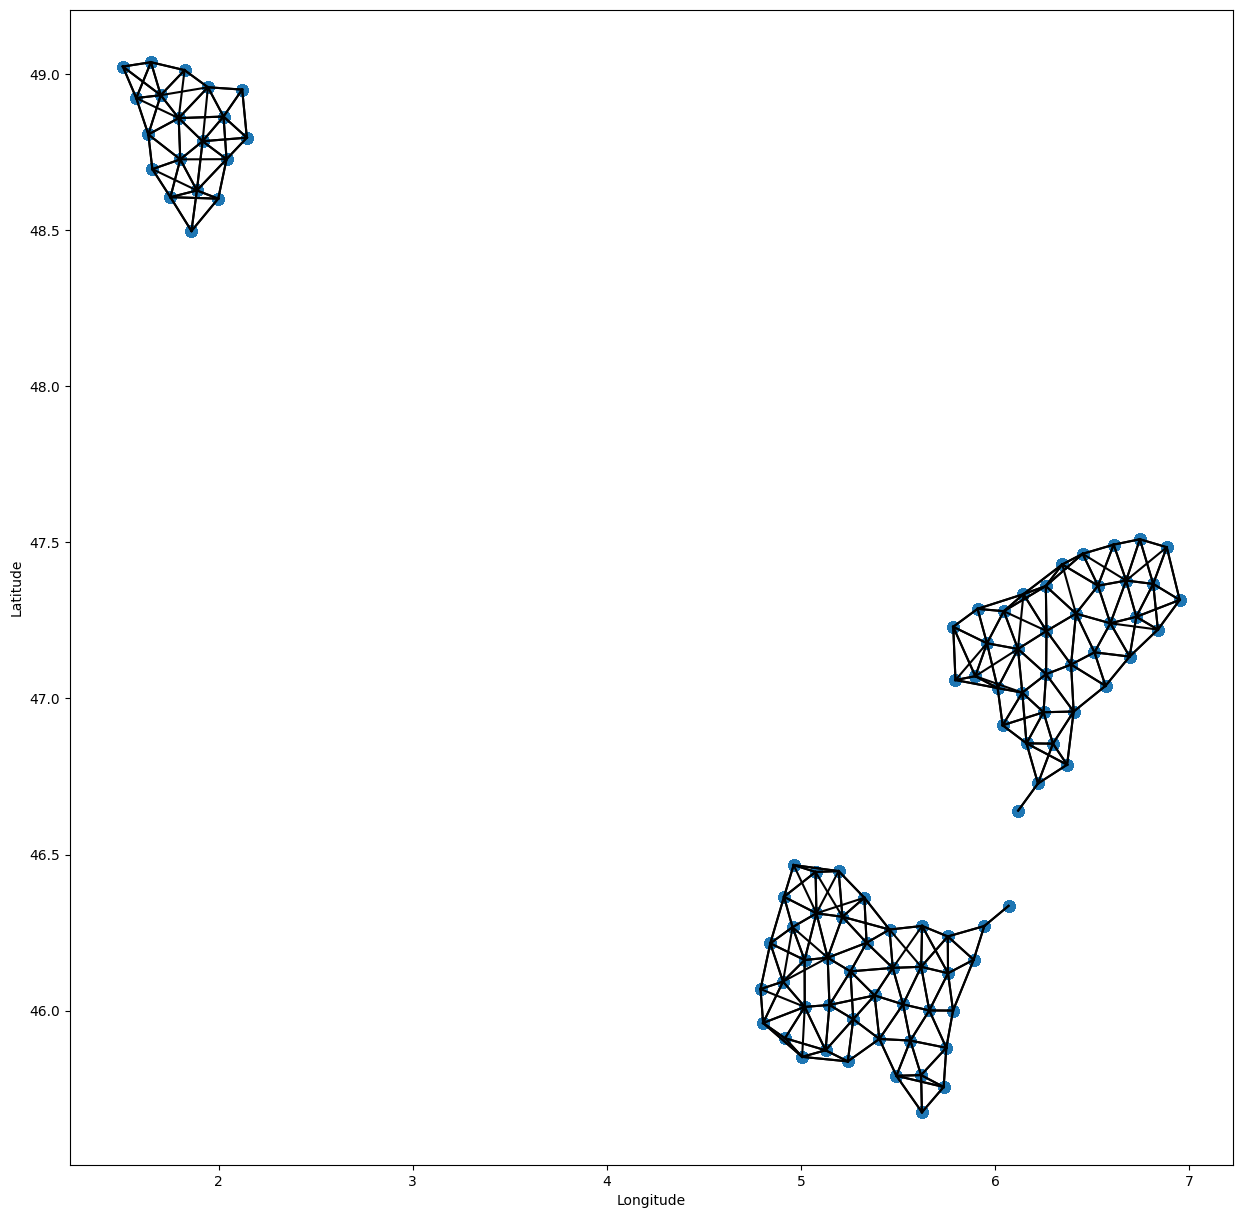

In [ ]:
graph = pickle.load(open('train/graph_5.pkl', 'rb'))
graph._plot(X)

In [ ]:
X.shape

(26520, 158)

In [ ]:
YBin[:,-1].sum()

1970.0

In [ ]:
Y.shape

(26520, 7)

In [ ]:
np.unique(X[mask][:,3])

array([ 1., 25., 69., 78.])

In [ ]:
allDates[2281]

'2023-09-10'

In [ ]:
Y[:,5]

array([1.11650485, 1.11650485, 1.11650485, ..., 1.19791667, 1.19791667,
       1.11650485])

In [ ]:
np.unique(X[:,4])

array([0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 1.0088e+01, 1.0569e+01,
       1.5969e+01])

In [ ]:
np.unique(Y[:,4])

array([ 1.        ,  1.11650485,  1.19791667,  1.43161094,  1.67151163,
        2.03396226,  3.14      ,  3.9057971 ,  5.22727273,  8.64220183,
       10.36538462, 29.94444444, 62.8       ])

In [ ]:
Y.shape

(47443, 6)

In [ ]:
np.argwhere(np.isnan(X))

array([[    0,   117],
       [    0,   118],
       [    0,   119],
       ...,
       [47506,   134],
       [47506,   135],
       [47506,   136]])

In [ ]:
np.unique(np.isnan(X))

array([False,  True])

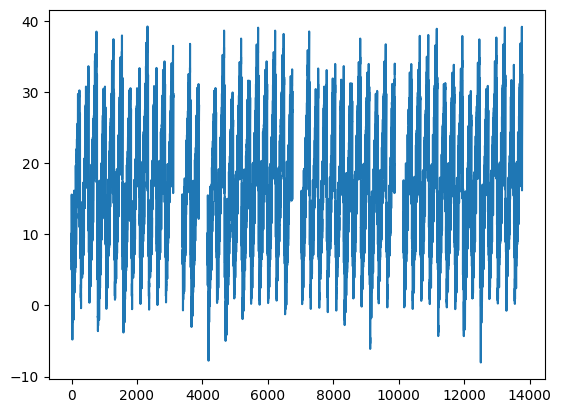

In [ ]:
plt.plot(X[:,6])

In [ ]:
np.unique(Y[Y[:,3] == 25][:,0])

array([ 2.,  4.,  5.,  7., 12., 13., 15., 23., 26., 27., 29., 34., 36.,
       39., 40., 43., 44., 46., 51., 55., 57., 59., 64., 69., 70., 75.,
       76., 77., 80., 81., 83., 84., 87., 88., 89., 91., 92., 98.])

In [ ]:
np.unique(YBin[:,-2])

array([0.        , 1.        , 1.11650485, 1.19791667, 1.43161094,
       1.67151163, 2.03396226, 3.14      , 3.9057971 , 5.22727273])

In [ ]:
Y[Y[:,5]>0].shape

(37579, 6)

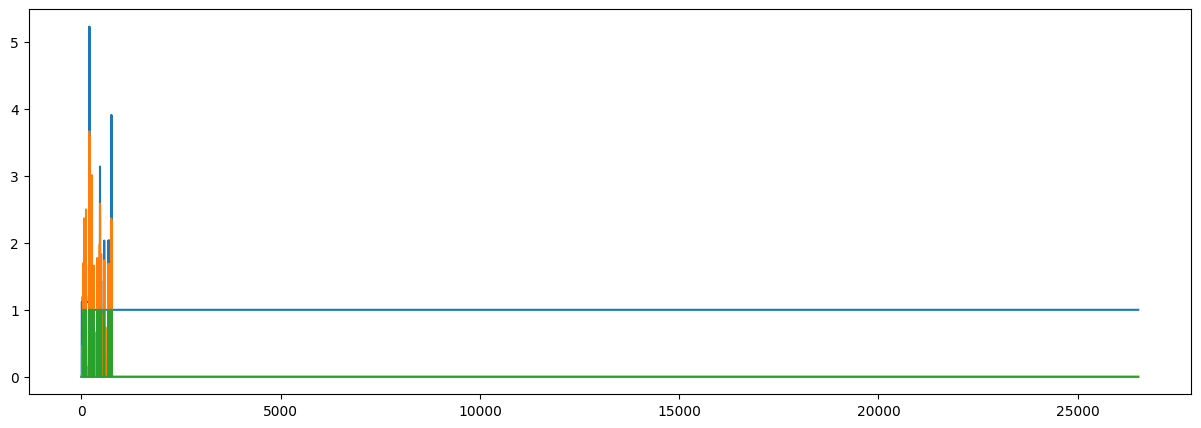

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(Y[:,-2])
plt.plot(Y[:,-1])
plt.plot(YBin[:,-1])

In [ ]:
np.sum(YBin[Y[:,3] == 1][:,-1])

751.0

In [ ]:
firepoint = firepoint[(firepoint['date'] > '2023-01-01') & (firepoint['date'] < '2023-10-04') ]
firepoint['date'] = [allDates.index(date) for date in firepoint.date]
y = np.ones(len(firepoint))
x = firepoint.date

In [ ]:
YBin = np.copy(Y)
YBin[:,-2] = YBin[:,-1] > 0

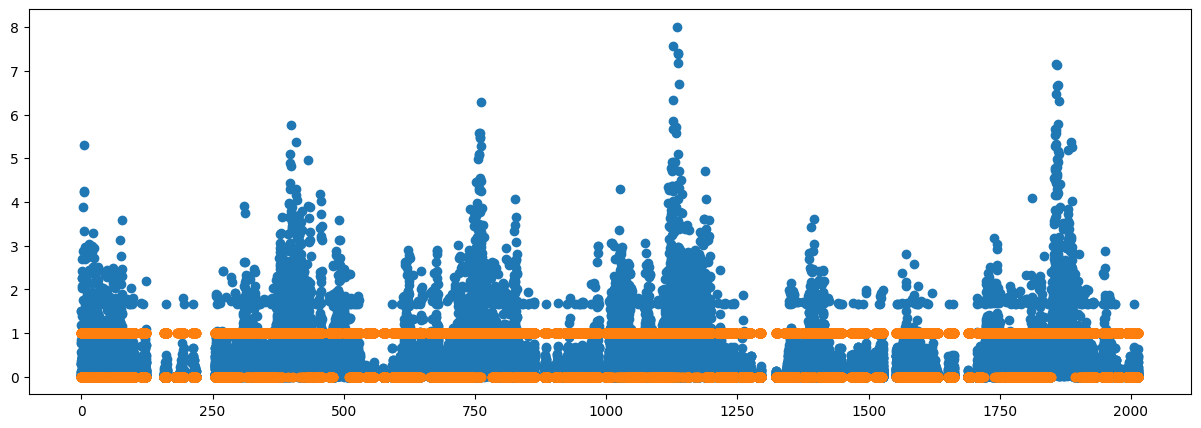

In [ ]:
plt.figure(figsize=(15,5))
#plt.scatter(YBin[Y[:,3] == 25][:,4], Y[Y[:,3] == 25][:,-2])
plt.scatter(YBin[Y[:,3] == 25][:,4], Y[Y[:,3] == 25][:,-1])
plt.scatter(YBin[Y[:,3] == 25][:,4], YBin[Y[:,3] == 25][:,-2])

In [ ]:
np.unique(YBin[:,0])

array([  0.,   1.,   2.,   3.,   4.,   5.,   7.,   8.,   9.,  10.,  12.,
        13.,  14.,  15.,  16.,  17.,  18.,  19.,  21.,  22.,  23.,  24.,
        25.,  26.,  27.,  28.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,
        39.,  40.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,
        52.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,
        64.,  65.,  67.,  70.,  71.,  72.,  73.,  75.,  76.,  77.,  79.,
        80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,
        91.,  92.,  93.,  94.,  95.,  96.,  98.,  99., 101., 103., 104.,
       105., 106., 107., 108., 109., 110., 111., 112., 113., 114., 115.,
       116., 117., 118.])

In [ ]:
YBin[(YBin[:,0] == 2) & (YBin[:,4] == 2073)][:,-1]

array([0.])

In [ ]:
YBin[(YBin[:,4] == 2074)][:,-1], Y[(Y[:,4] == 2074)][:,0]

(array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   7.,   8.,   9.,  10.,  12.,
         13.,  14.,  15.,  16.,  17.,  18.,  19.,  21.,  22.,  23.,  24.,
         25.,  26.,  27.,  28.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,
         39.,  40.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,
         52.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,
         64.,  65.,  67.,  70.,  71.,  72.,  73.,  75.,  76.,  77.,  79.,
         80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,
         91.,  92.,  93.

In [ ]:
YBin[(YBin[:,4] == 2073)][:,-1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

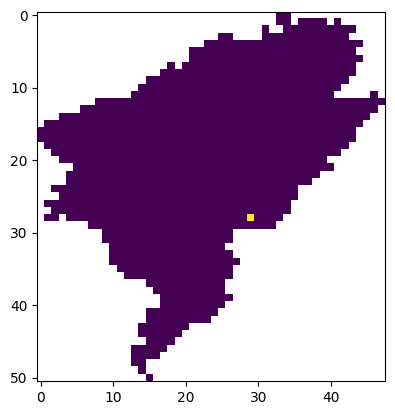

In [ ]:
plt.imshow(bin[:,:,2075])

In [ ]:
firepoint

,date_debut,date_fin,1er engin SLL,raison_sortie,date,geometry,latitude,longitude,IN,type,coef,label,altitude,h3,scale
2765,2023-01-10 18:09:48,2023-01-10 19:51:29,-,NATURELS,2038,POINT (6.252583644154578 47.30947220067402),47.309472,6.252584,True,NATURELS,1,1,260.0,871f828e1ffffff,90
2766,2023-02-09 18:13:13,2023-02-09 19:34:54,2023-02-09 18:26:13,NATURELS,2068,POINT (6.882795615283376 47.42495144013152),47.424951,6.882796,True,NATURELS,1,1,0.0,871f82b4bffffff,111
2767,2023-02-13 17:38:28,2023-02-13 19:30:55,2023-02-13 17:59:03,NATURELS,2072,POINT (6.80571257239119 47.34940666527785),47.349407,6.805713,True,NATURELS,1,1,0.0,871f82a70ffffff,63
2768,2023-02-15 17:06:24,2023-02-15 17:38:51,2023-02-15 17:16:21,NATURELS,2074,POINT (6.052971523002236 47.24917343655492),47.249173,6.052972,True,NATURELS,1,1,0.0,871f828aaffffff,98
2769,2023-02-16 16:00:24,2023-02-16 16:36:29,2023-02-16 16:22:07,NATURELS,2075,POINT (6.5364849265341 46.995227573854905),46.995228,6.536485,True,NATURELS,1,1,965.0,871f8205dffffff,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2972,2023-08-26 06:43:58,2023-08-26 07:33:27,2023-08-26 06:58:19,NATURELS,2266,POINT (6.315552969460393 46.929482129860986),46.929482,6.315553,True,NATURELS,1,1,0.0,871f820f4ffffff,46
2973,2023-08-31 21:15:38,2023-08-31 23:09:11,2023-08-31 21:34:08,NATURELS,2271,POINT (6.580298042930016 47.22287875831443),47.222879,6.580298,True,NATURELS,1,1,740.0,871f82aa3ffffff,95
2974,2023-09-02 03:55:54,2023-09-02 05:45:22,2023-09-02 04:12:35,NATURELS,2273,POINT (6.88968342990473 47.265828259997825),47.265828,6.889683,True,NATURELS,1,1,0.0,871f82aedffffff,87
2975,2023-09-02 15:19:34,2023-09-02 17:29:32,2023-09-02 15:35:53,NATURELS,2273,POINT (6.088833947084734 47.341352484097094),47.341352,6.088834,True,NATURELS,1,1,250.0,871f82811ffffff,44


In [ ]:
np.unique(raster)

array([ 2.,  4.,  5.,  7., 12., 13., 15., 23., 26., 27., 29., 34., 36.,
       39., 40., 43., 44., 46., 51., 55., 57., 59., 64., 69., 70., 75.,
       76., 77., 80., 81., 83., 84., 87., 88., 89., 91., 92., 98., nan],
      dtype=float32)

In [ ]:
X.shape

(26520, 162)

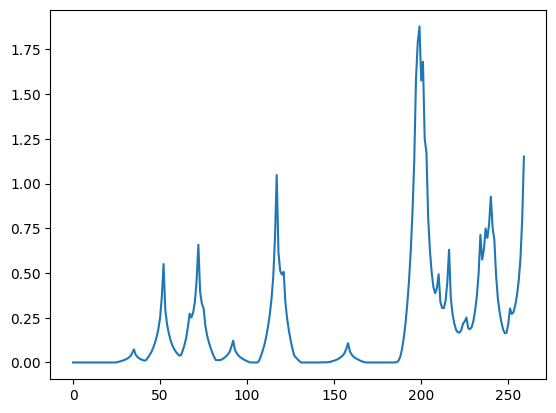

In [ ]:
plt.plot(X[X[:,0] == 0][:,-4])

In [ ]:
X[X[:,0] == 0].shape

(260, 162)

In [ ]:
Y[Y[:,0] == 0].shape

(260, 7)

In [ ]:
np.sum(YBin[:,-1])

26.0

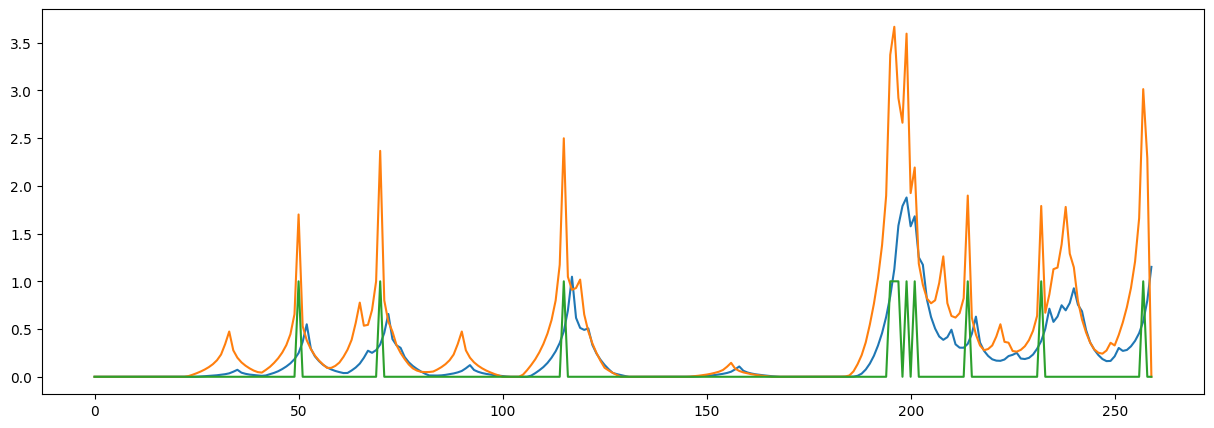

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(X[X[:,0] == 0][:,-4])
plt.plot(Y[Y[:,0] == 0][:,-1])
plt.plot(YBin[Y[:,0] == 0][:,-1])

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(Y[Y[:,0] == 3][:,-2])

In [ ]:
np.unique(Y[:,-1])

array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
       0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044, 0.045,
       0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053, 0.054,
       0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062, 0.063,
       0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071, 0.072,
       0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 , 0.081,
       0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089, 0.09 ,
       0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099,
       0.1  , 0.101, 0.102, 0.103, 0.104, 0.105, 0.106, 0.107, 0.108,
       0.109, 0.11 , 0.111, 0.112, 0.113, 0.114, 0.115, 0.116, 0.117,
       0.118, 0.119, 0.12 , 0.121, 0.122, 0.123, 0.124, 0.125, 0.126,
       0.127, 0.128,

(array([4.1414e+04, 3.1360e+03, 9.0700e+02, 2.7700e+02, 9.5000e+01,
        3.7000e+01, 1.4000e+01, 7.0000e+00, 1.0000e+00, 5.0000e+00]),
 array([ 0.    ,  1.0569,  2.1138,  3.1707,  4.2276,  5.2845,  6.3414,
         7.3983,  8.4552,  9.5121, 10.569 ]),
 <BarContainer object of 10 artists>)

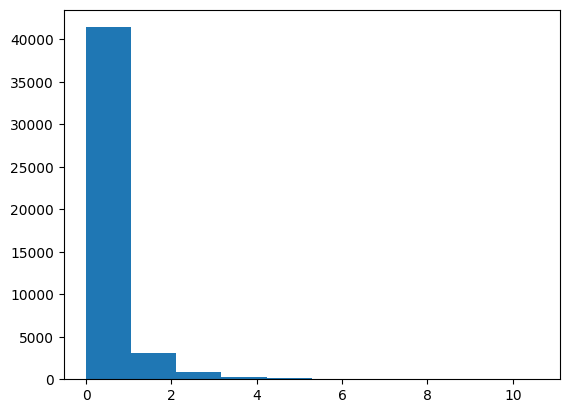

In [ ]:
plt.hist(Y[:,-1])

In [ ]:
YBin[:,-1][(Y[:,-1] > 0.1) & (Y[:,-1] < 0.2)]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
quantile_prediction_error(torch.tensor(YBin[:,-1], dtype=torch.float32), torch.tensor(Y[:,-1], dtype=torch.float32), 'mean')

0.21435234 0.0
1.5277762 0.30070153
2.5212095 0.62844545
3.586372 0.68231046
4.6870737 0.7368421
5.7341623 0.7567568
6.820286 1.0
7.777286 0.85714287
8.943 1.0
9.90975 1.0


4.4759073

In [ ]:
graph.X[graph.X[:,3] == 78][:,5]

array([100., 100., 100., ..., 139., 139., 139.])

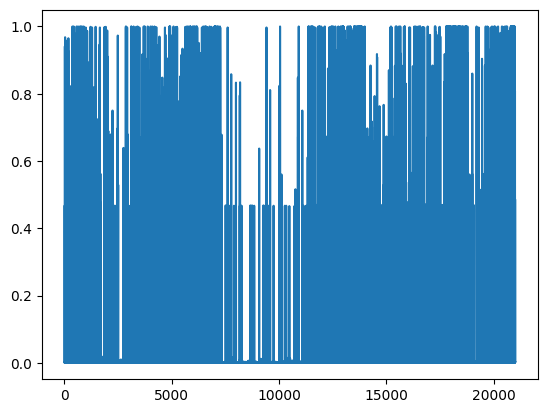

In [ ]:
plt.plot(Y[:,-1])

(array([142659.,   6579.,   2161.,  10701.,   1310.]),
 array([0.  , 0.5 , 0.75, 1.  , 2.  , 3.  ]),
 <BarContainer object of 5 artists>)

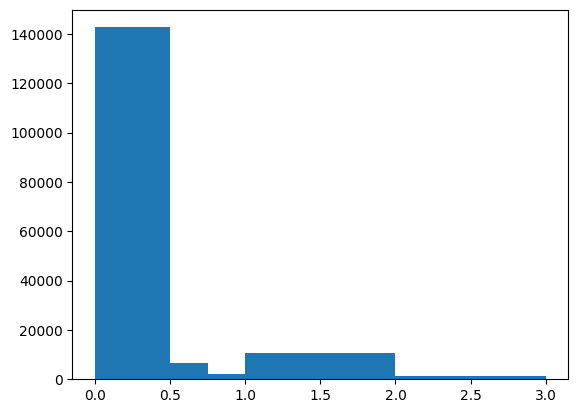

In [ ]:
plt.hist(Y[:,-1], bins=[0,0.5,0.75,1,2,3])

In [ ]:
np.unique(graph.X[:,3])

array([ 1., 25., 78.])

<Axes: >

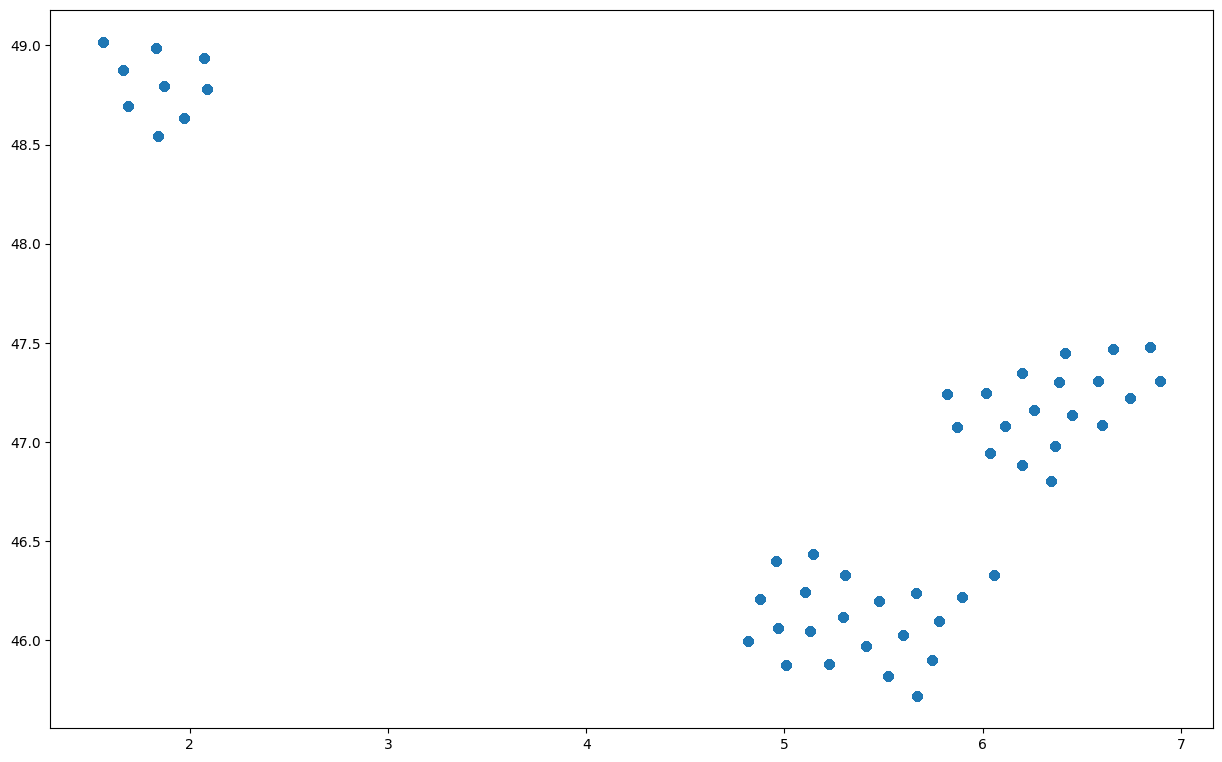

In [ ]:
geo = gpd.GeoDataFrame(geometry=gpd.points_from_xy(graph.X[:,1], graph.X[:,2]))
geo['elevation'] = graph.Y[:,-1]
geo.plot(figsize=(15,15))

0.26494083441510796 0.8696011440457618 0.07167263236390753


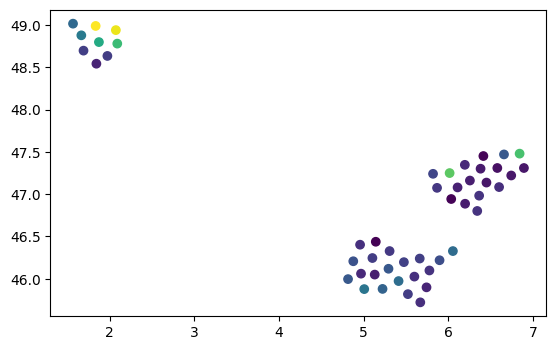

In [ ]:
geo2 = geo.groupby('geometry')['elevation'].mean().reset_index()
geo3 = gpd.GeoDataFrame(geometry=geo2.geometry)
geo3['elevation'] = geo2['elevation']
geo3.plot(column='elevation')
print(geo3.elevation.mean(), geo3.elevation.max(), geo3.elevation.min())

In [ ]:
Y.shape

(52505, 7)

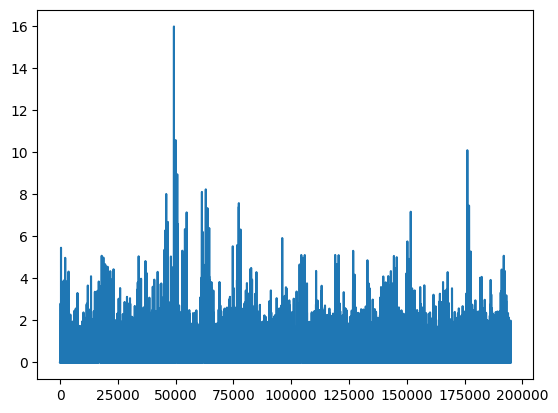

In [ ]:
ind = np.lexsort((Y[:,4], Y[:,0]))
order = Y[ind]
plt.plot((order[:,-1]))

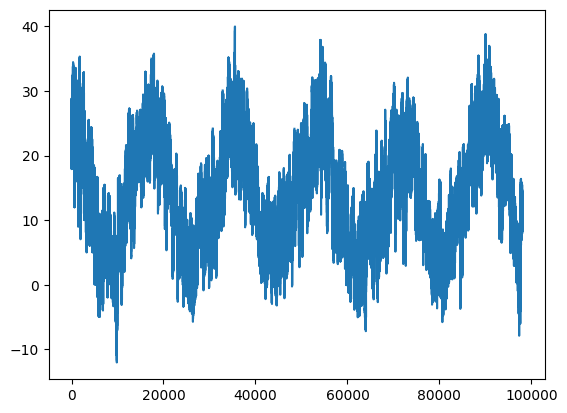

In [ ]:
fig, ax = plt.subplots(1, figure=(15,5))

ind = np.lexsort([Y[:,4]])
order = X[ind]
ax.plot(order[:,6])
#ax.plot(order[:,31])

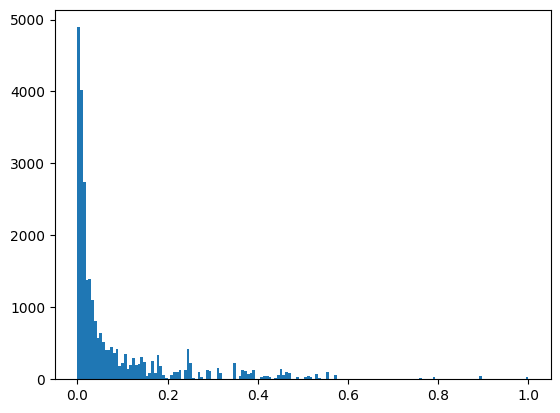

In [ ]:
plt.hist(order[:,-1], bins='auto')
plt.show()

In [ ]:
nodes = graph.X
graphIds = np.unique(nodes[:,5])

size = []
dates = []
for graphid in graphIds:
    size.append(nodes[nodes[:,5] == graphid].shape[0])
    dates.append(np.unique(nodes[nodes[:,5] == graphid][:,4]).shape[0])

print(graphIds[np.argwhere(size == np.max(size))])

print(graphIds[np.argwhere(size == 13)])

[[  0.]
 [  1.]
 [  2.]
 [  3.]
 [  4.]
 [  5.]
 [  6.]
 [  7.]
 [  8.]
 [  9.]
 [ 10.]
 [ 11.]
 [ 12.]
 [ 13.]
 [ 14.]
 [ 15.]
 [ 16.]
 [ 17.]
 [ 18.]
 [ 19.]
 [ 20.]
 [ 21.]
 [ 22.]
 [ 23.]
 [ 24.]
 [ 25.]
 [ 26.]
 [ 27.]
 [ 28.]
 [ 29.]
 [ 30.]
 [ 31.]
 [ 32.]
 [ 33.]
 [ 34.]
 [ 35.]
 [ 36.]
 [ 37.]
 [ 38.]
 [ 39.]
 [ 40.]
 [ 41.]
 [ 42.]
 [ 43.]
 [ 44.]
 [ 45.]
 [ 46.]
 [ 47.]
 [ 48.]
 [ 49.]
 [ 50.]
 [ 51.]
 [ 52.]
 [ 53.]
 [ 54.]
 [ 55.]
 [ 56.]
 [ 57.]
 [ 58.]
 [ 59.]
 [ 60.]
 [ 61.]
 [ 62.]
 [ 63.]
 [ 64.]
 [ 65.]
 [ 66.]
 [ 67.]
 [ 68.]
 [ 69.]
 [ 70.]
 [ 71.]
 [ 72.]
 [ 73.]
 [ 74.]
 [ 75.]
 [ 76.]
 [ 77.]
 [ 78.]
 [ 79.]
 [ 80.]
 [ 81.]
 [ 82.]
 [ 83.]
 [ 84.]
 [ 85.]
 [ 86.]
 [ 87.]
 [ 88.]
 [ 89.]
 [ 90.]
 [ 91.]
 [ 92.]
 [ 93.]
 [ 94.]
 [ 95.]
 [ 96.]
 [ 97.]
 [ 98.]
 [ 99.]
 [100.]
 [101.]
 [102.]
 [103.]
 [104.]
 [105.]
 [106.]
 [107.]
 [108.]
 [109.]
 [110.]
 [111.]
 [112.]
 [113.]
 [114.]
 [115.]
 [116.]
 [117.]
 [118.]
 [119.]
 [120.]
 [121.]
 [122.]
 [123.]
 [124.]


In [ ]:
np.unique(size)

array([ 10,  20,  40,  60,  76,  80, 100, 114, 120])

In [ ]:
np.unique(size)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [ ]:
print(graphIds[np.argwhere(size == np.unique(size)[9])])

[[ 421.]
 [ 460.]
 [ 468.]
 [ 654.]
 [1986.]
 [2127.]
 [2312.]
 [3016.]
 [3078.]
 [6160.]]


In [ ]:
graph.X[graph.X[:,5] == 11179]

array([[4.70000000e+01, 4.98762633e+00, 4.58900001e+01, ...,
        7.47741419e-02, 1.62194104e-01, 1.63115261e-01],
       [0.00000000e+00, 5.37884368e+00, 4.59693338e+01, ...,
        9.94515280e-02, 1.71393730e-01, 1.30327546e-01],
       [2.30000000e+01, 6.83802670e+00, 4.74821367e+01, ...,
        4.26461220e-02, 2.36615430e-01, 2.71288549e-01],
       ...,
       [1.50000000e+01, 5.65755384e+00, 4.62434403e+01, ...,
        6.38735691e-03, 1.73499745e-01, 1.67420405e-01],
       [4.20000000e+01, 6.05849674e+00, 4.69340218e+01, ...,
        7.26705280e-03, 2.03560835e-02, 7.66408623e-03],
       [2.90000000e+01, 6.05427776e+00, 4.71022063e+01, ...,
        2.60772433e-02, 1.81698265e-02, 1.18047537e-02]])

In [ ]:
unique = graph.X[graph.X[:,5] == 1903]

for u in unique:
    nei = graph.edges[1][graph.edges[0] == u[0]]
    m = np.argwhere(np.isin(graph.X[:,0], nei) & (graph.X[:,4] == u[4]))
    print(m.shape)

(2, 1)
(2, 1)
(2, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)


In [ ]:
graph.edges[1][np.argwhere((np.isin(graph.edges[1], [ 887., 3000., 2963., 2975., 1285., 1190., 2942., 1229., 3018.,
        391., 1059., 1105.,  135.,  369., 2864., 2996.,  334., 1076.,
       2962., 2913., 2835., 2998.,  251., 2999.,  982., 2828., 2863.,
       2982.,  620., 2943.])) & (graph.edges[0] == 1076))]

array([], shape=(0, 1), dtype=int64)

In [ ]:
graph.X[(graph.X[:,5] == 14618) & (np.isin(graph.X[:,0], [1076.0]))][:,0]

array([1076.])

In [ ]:
graph.X[graph.X[:,5] == 1][:,4]

array([680., 680., 680., 680., 680., 680., 680., 680., 680., 680., 680.,
       680., 680., 680., 680., 680., 680., 680., 680., 680., 679., 678.,
       677., 676., 675., 679., 678., 677., 676., 675., 679., 678., 677.,
       676., 675., 679., 678., 677., 676., 675., 679., 678., 677., 676.,
       675., 679., 678., 677., 676., 675., 679., 678., 677., 676., 675.,
       679., 678., 677., 676., 675., 679., 678., 677., 676., 675., 679.,
       678., 677., 676., 675., 679., 678., 677., 676., 675., 679., 678.,
       677., 676., 675., 679., 678., 677., 676., 675., 679., 678., 677.,
       676., 675., 679., 678., 677., 676., 675., 679., 678., 677., 676.,
       675., 679., 678., 677., 676., 675., 679., 678., 677., 676., 675.,
       679., 678., 677., 676., 675., 679., 678., 677., 676., 675.])

In [ ]:
X

array([[28.        ,  5.46865663, 46.17864005, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.        ,  5.292747  , 46.11412999, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.        ,  5.75132142, 45.93599172, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  1.96556147, 48.63685383, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  1.96556147, 48.63685383, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  1.96556147, 48.63685383, ...,  0.        ,
         0.        ,  0.        ]])

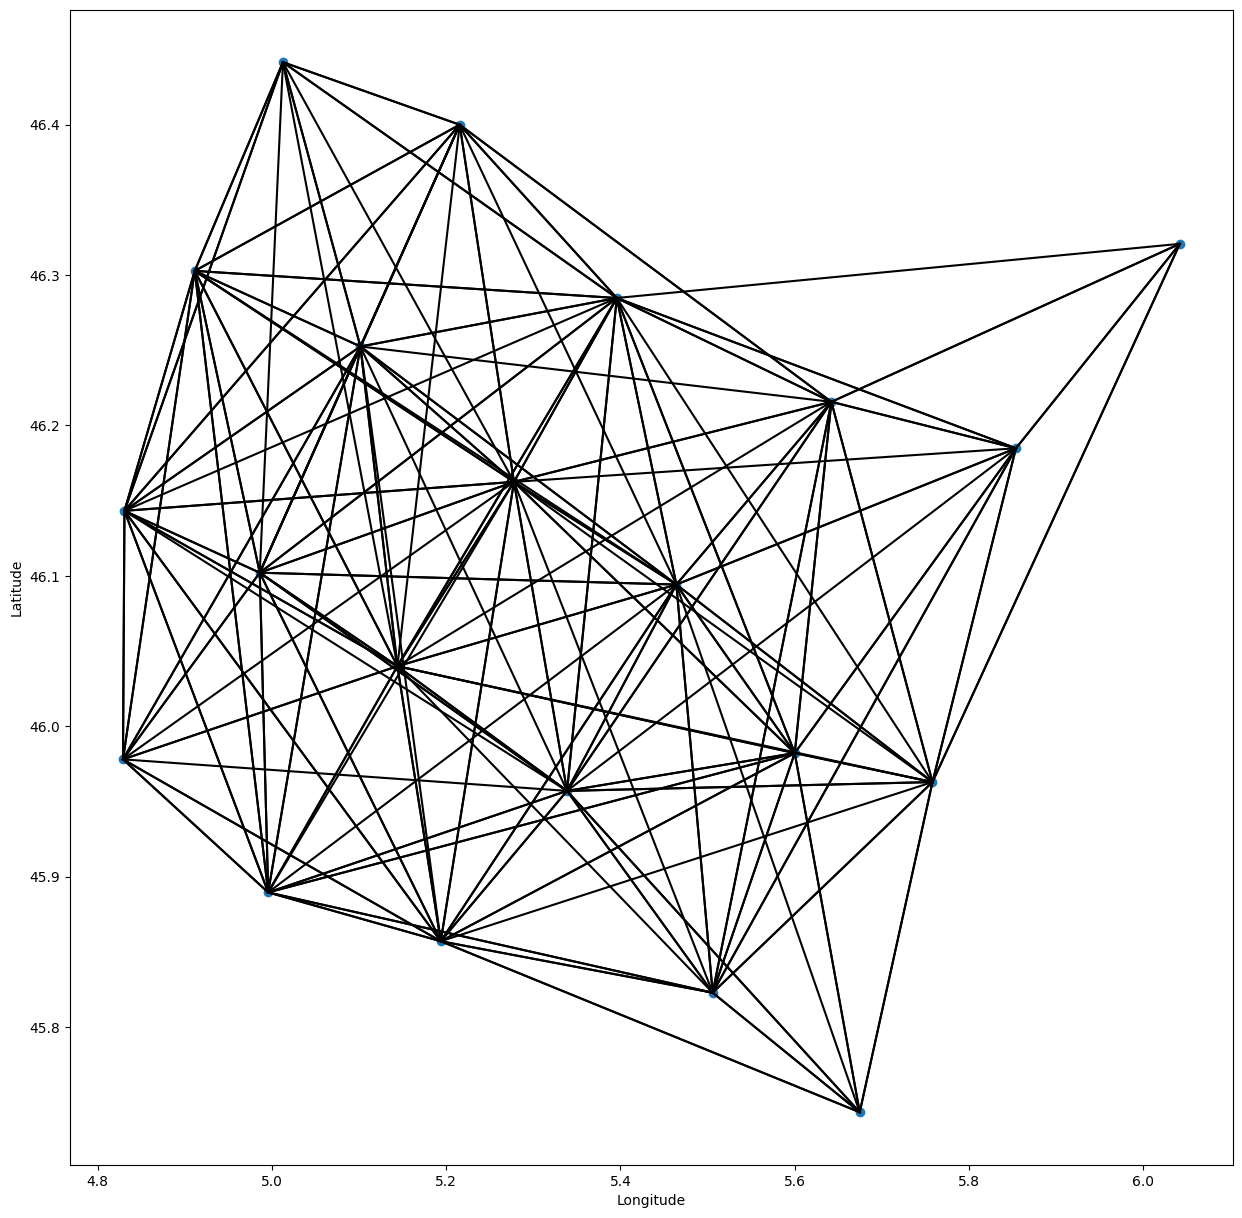

In [ ]:
graph._plot(X[X[:,4] == 1654], time=0)

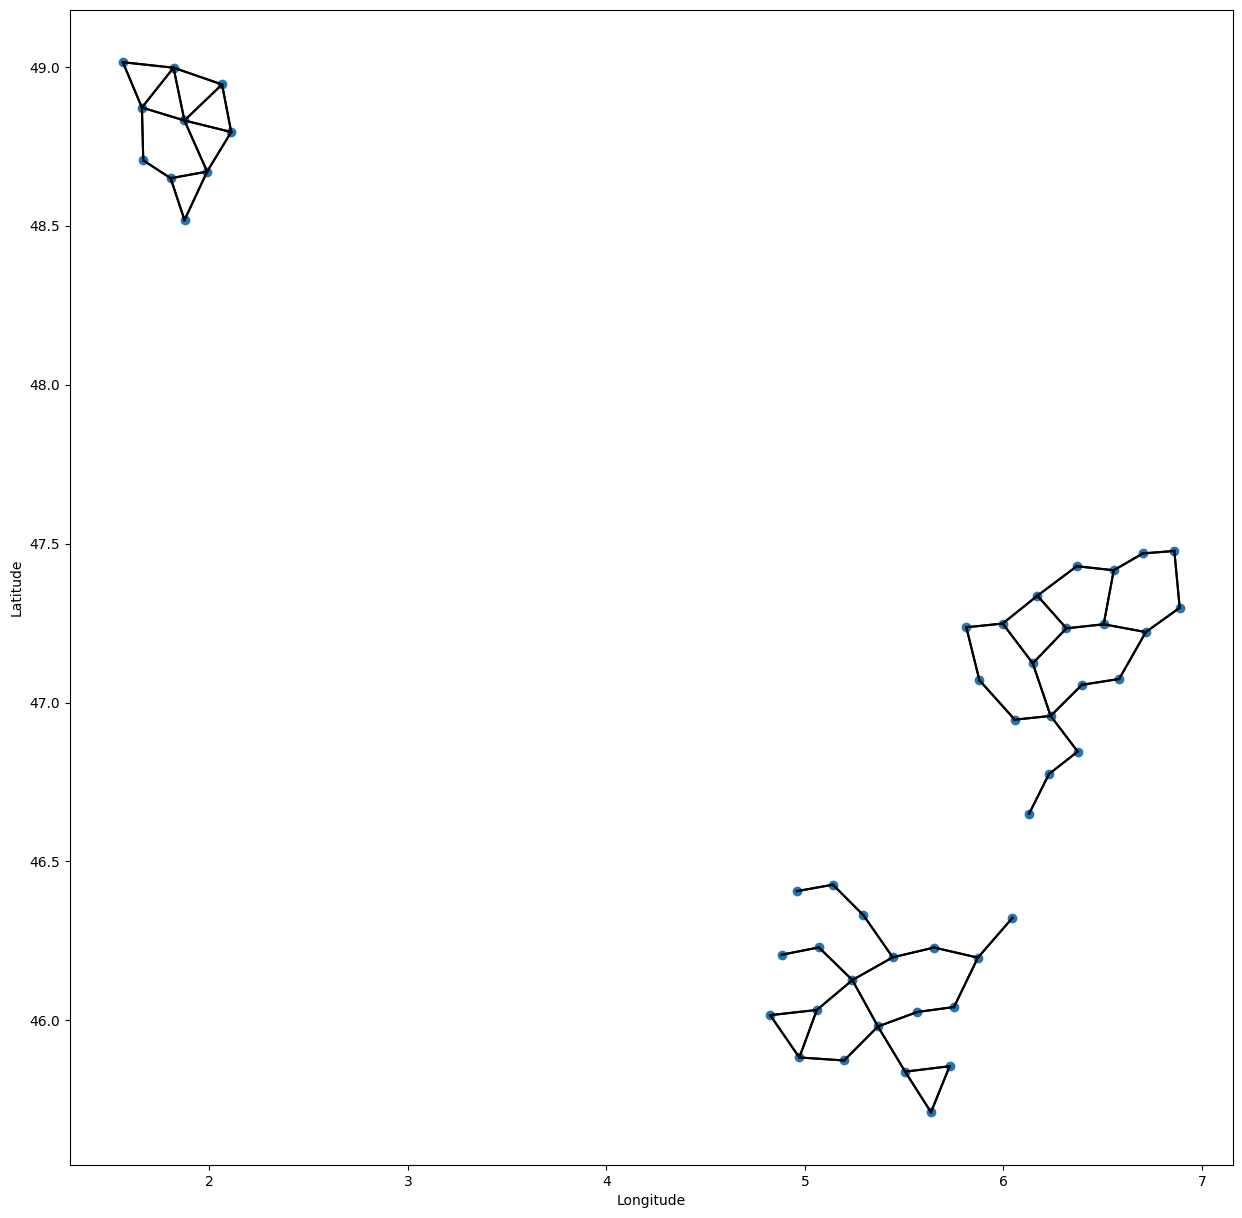

In [ ]:
graph._plot(graph.nodes, time=0)

In [ ]:
np.unique(graph.X[:,5] == -1)

array([False])

In [ ]:
graph.X[graph.X[:,5] == 588].shape

(16, 10)

[   0.    3.    5. ... 2775. 2776.   nan]


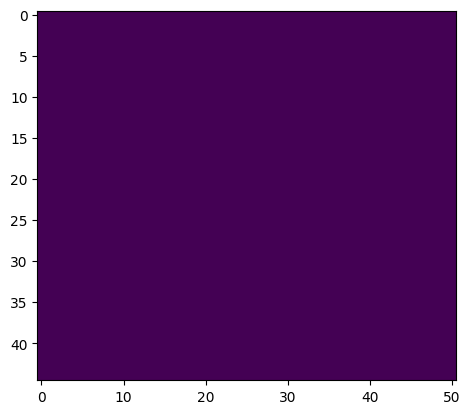

In [ ]:
raster = pickle.load(open('train/raster/departement-01-ainrasterScale0.pkl', 'rb'))
print(np.unique(raster[:,:]))
plt.imshow(raster == 781)

[584. 591. 833. 885.  nan]


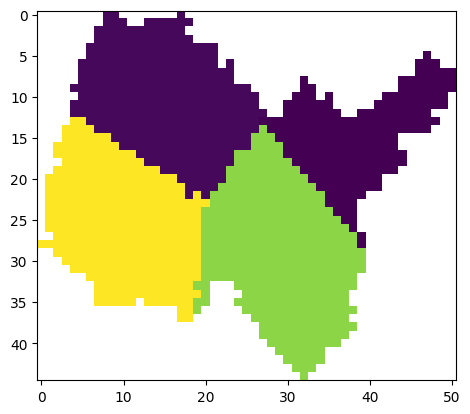

In [ ]:
raster = pickle.load(open('train/bin/departement-01-ainbinScale50.pkl', 'rb'))
print(np.unique(raster))
plt.imshow(raster[:,:,0])

[ 1. nan]


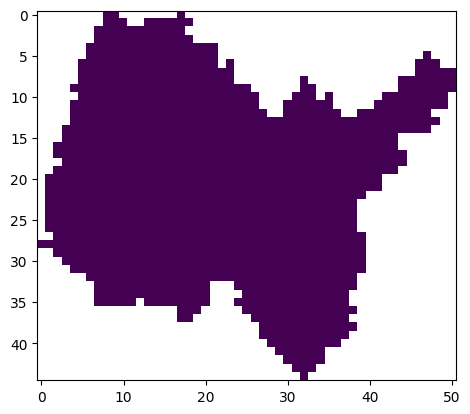

In [ ]:
raster = pickle.load(open('train/proba/departement-01-ainprobaScale50.pkl', 'rb'))
print(np.unique(raster[:,:,0]))
plt.imshow(raster[:,:,0])